# population-inference
notebook for running vectorised inference over a population of hares or emus

In [1]:
#stock imports
import tensorflow as tf
import numpy as np
import pandas as pd
import json
import pickle
import scipy
import os
##plotting
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import corner

#script imports
from scripts import prior_funcs, utils

from scripts.pitchfuncs_ultra_pca import emulator
from scripts.pitchfuncs_ultra_pca import ultra_ns_vector_nice
from scripts.pitchfuncs_ultra_pca import ultra_ns_vector_simpleslice
from scripts.pitchfuncs_ultra_pca import ultra_ns_vector_slice
from scripts.pitchfuncs_ultra_pca import ultra_ns_vector_walk


os.environ["CUDA_VISIBLE_DEVICES"]="0"

physical_devices = tf.config.list_physical_devices("GPU") 

tf.config.experimental.set_memory_growth(physical_devices[0], True)

gpu0usage = tf.config.experimental.get_memory_info("GPU:0")["current"]

2024-06-24 12:00:38.847778: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-24 12:00:38.847843: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-24 12:00:38.866647: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-24 12:00:38.905303: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-24 12:00:39.583681: W tensorflow/compiler/tf2

## import neural network

In [2]:
pitchfork_name = "nu6-40_elu_nonorm_feh"
pitchfork = emulator(pitchfork_name)

with open("pitchfork/" +pitchfork_name+ ".pkl", 'rb') as fp:
     pitchfork_info = pickle.load(fp)

pitchfork_ranges = pitchfork_info['parameter_ranges']

initial_mass range: [min = 0.8, max = 1.2]
initial_Zinit range: [min = 0.003869061466818601, max = 0.0389797119014747]
initial_Yinit range: [min = 0.24, max = 0.32]
initial_MLT range: [min = 1.7, max = 2.5]
star_age range: [min = 0.029664111540787196, max = 13.999973871651315]


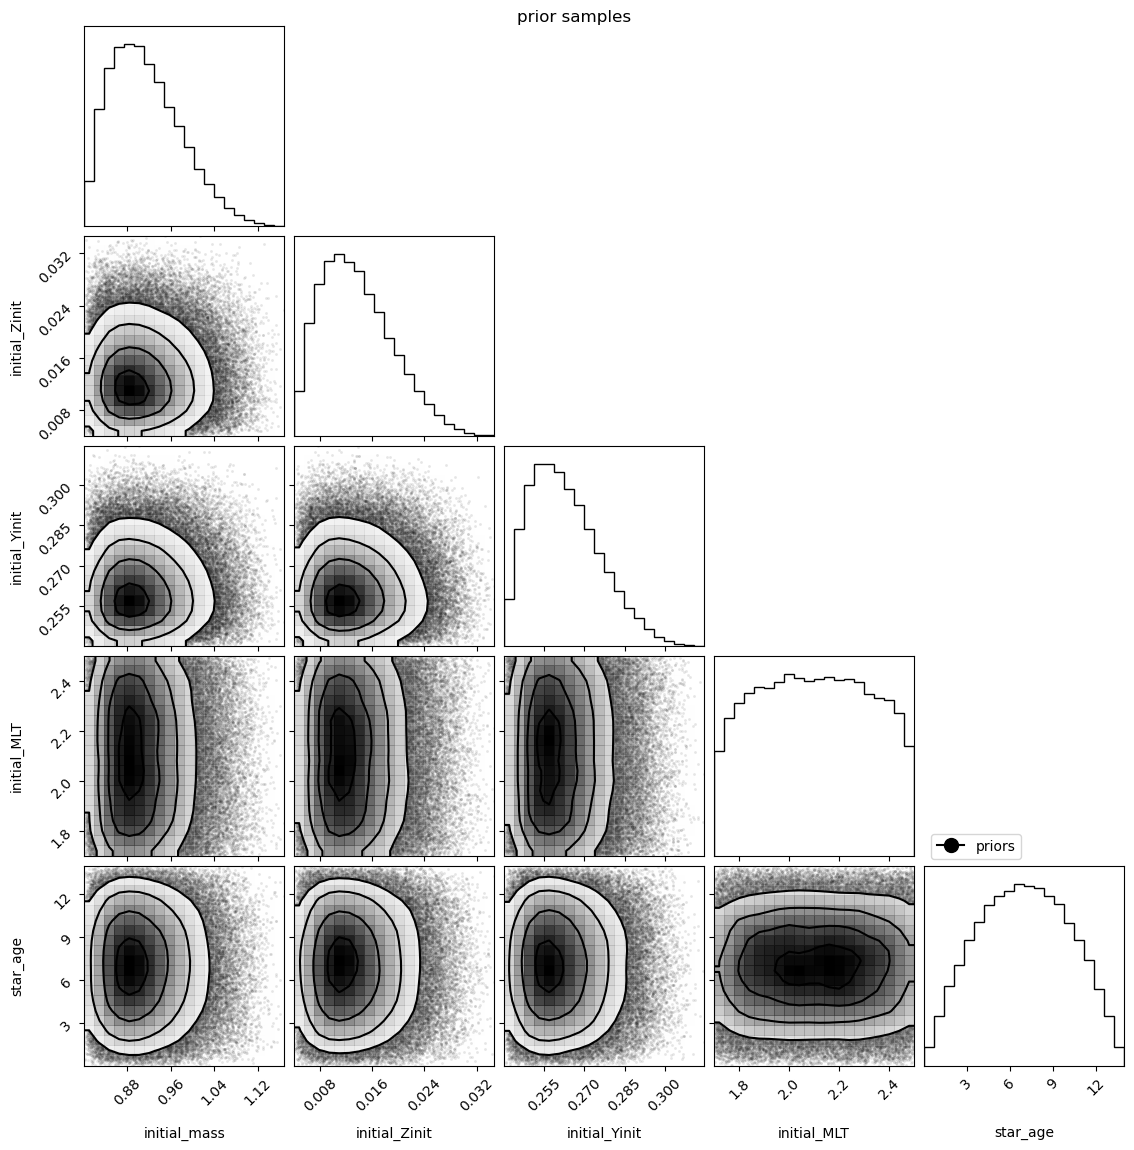

In [3]:
labels = ['initial_mass', 'initial_Zinit', 'initial_Yinit', 'initial_MLT', 'star_age']

mass_prior = prior_funcs.custom_beta_prior(0.8, 1.2, a=2, b=5)

Zinit_prior = prior_funcs.custom_beta_prior(0.004, 0.038, a=2, b=5)

Yinit_prior = prior_funcs.custom_beta_prior(0.24, 0.32, a=2, b=5)

MLT_prior = prior_funcs.custom_beta_prior(1.7, 2.5, a=1.2, b=1.2)

age_prior = prior_funcs.custom_beta_prior(0.03, 14, a=2, b=2)


priors = [mass_prior, Zinit_prior, Yinit_prior, MLT_prior, age_prior]

size = 100000
plot_prior_samples = np.array([prior.rvs(size=size) for prior in priors])
legend_labels = []
corner_color = 'black'
corner.corner(plot_prior_samples.T, labels = labels, color=corner_color, hist_kwargs={'density':True}, smooth=True);
legend_labels = legend_labels + [Line2D([0], [0], marker='o', color =corner_color, markerfacecolor = corner_color, markersize=10, label='priors')]
plt.suptitle('prior samples')
plt.legend(handles=legend_labels, bbox_to_anchor=(0., 1.0, 1., .0), loc=0)
plt.show()

In [ ]:
%%time

with open("pitchfork/emulator_cov.pkl", 'rb') as fp:
     sigma_nn = pickle.load(fp)

ndraw_min=2**16
ndraw_max=2**16

for obs_idx in range(5):
    for hare_idx in range(100):
        path = f'form/hare{hare_idx}/obs{obs_idx}/'
        hare_observed = pd.read_json(path+f'obs{obs_idx}.json')
        hare_uncs = pd.read_json(path+'uncs.json')
        hare_uncs_array = hare_uncs.values[0]
    
        n_min = int(hare_uncs.drop(['calc_effective_T', 'luminosity', 'star_feh'], axis=1).columns[0].replace('nu_0_',''))
        n_max = int(hare_uncs.drop(['calc_effective_T', 'luminosity', 'star_feh'], axis=1).columns[-1].replace('nu_0_',''))
    
        sigma_nn_mask = np.zeros(len(sigma_nn), dtype=bool)
        sigma_nn_mask[:3] = True
        sigma_nn_mask[n_min-3:n_max-2] = True
    
        sigma_nn_cropped = sigma_nn[:,sigma_nn_mask][sigma_nn_mask,:]
    
        sigma_obs = (hare_uncs_array*hare_uncs_array)*(np.identity(len(hare_uncs_array)))
    
        sigma = sigma_nn_cropped + sigma_obs
    
        sigma_inv = np.linalg.inv(sigma)
    
        _, log_sigma_det = np.linalg.slogdet(sigma)
        
        outputs = ['calc_effective_T', 'luminosity', 'star_feh'] + [f'nu_0_{i}' for i in range(n_min,n_max+1)]
        
        sampler = ultra_ns_vector_simpleslice(priors=priors, observed_vals=hare_observed[outputs].values[0], pitchfork=pitchfork,log_sigma_det=log_sigma_det, sigma_inv=sigma_inv, n_min=n_min, n_max=n_max, logl_scale=1)
        results = sampler(ndraw_min, ndraw_max).run(min_num_live_points=400, frac_remain=.001)
        with open(path+'/samples.pkl', 'wb') as fp:
            pickle.dump(results, fp, protocol=pickle.HIGHEST_PROTOCOL)
    
        sampler.cleanup()
        del results

[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+01   [-13.4693..-13.4537] | it/evals=7240/974000 eff=0.7436% N=400   0 0     0 
[ultranest] Likelihood function evaluations: 974000
[ultranest]   logZ = -24.4 +- 0.1149
[ultranest] Effective samples strategy satisfied (ESS = 2152.7, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.05 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.11, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:0.11 tail:0.00 total:0.11 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+01   [-11.6127..-11.5874] | it/evals=7400/1102400 eff=0.6715% N=400       0 00 
[ultranest] Likelihood function evaluations: 1102400
[ultranest]   logZ = -22.54 +- 0.114
[ultranest] Effective samples strategy satisfied (ESS = 1941.8, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.08 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.11, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:0.11 tail:0.00 total:0.11 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+01   [-12.1830..-12.1010] | it/evals=8240/1312400 eff=0.6280% N=400   0   0  0 0 0 
[ultranest] Likelihood function evaluations: 1312400
[ultranest]   logZ = -25.23 +- 0.1122
[ultranest] Effective samples strategy satisfied (ESS = 2103.7, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.05 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.11, need <0.5)
[ultranest]   logZ error budget: single: 0.16 bs:0.11 tail:0.00 total:0.11 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+01   [-15.2365..-15.2029] | it/evals=8320/1142400 eff=0.7285% N=400 0 00  0  0  
[ultranest] Likelihood function evaluations: 1142400
[ultranest]   logZ = -28.78 +- 0.1231
[ultranest] Effective samples strategy satisfied (ESS = 2226.8, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.12, need <0.5)
[ultranest]   logZ error budget: single: 0.17 bs:0.12 tail:0.00 total:0.12 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+01   [-18.0270..-18.0076] | it/evals=7560/1176400 eff=0.6429% N=400    0  0  0  
[ultranest] Likelihood function evaluations: 1176400
[ultranest]   logZ = -29.5 +- 0.1131
[ultranest] Effective samples strategy satisfied (ESS = 2077.5, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.08 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.11, need <0.5)
[ultranest]   logZ error budget: single: 0.16 bs:0.11 tail:0.00 total:0.11 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-9  69 [-8.8358..-8.8046] | it/evals=7400/893600 eff=0.8285% N=400        0 0 0  0 0 0 
[ultranest] Likelihood function evaluations: 893600
[ultranest]   logZ = -20.45 +- 0.09266
[ultranest] Effective samples strategy satisfied (ESS = 1855.4, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.09, need <0.5)
[ultranest]   logZ error budget: single: 0.16 bs:0.09 tail:0.00 total:0.09 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+01   [-14.2213..-14.1989] | it/evals=7160/924000 eff=0.7752% N=400    0      0 
[ultranest] Likelihood function evaluations: 924000
[ultranest]   logZ = -25.21 +- 0.1165
[ultranest] Effective samples strategy satisfied (ESS = 1965.8, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.12, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:0.12 tail:0.00 total:0.12 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+01   [-10.2409..-10.1937] | it/evals=8280/1196400 eff=0.6923% N=400       0  0  
[ultranest] Likelihood function evaluations: 1196400
[ultranest]   logZ = -23.47 +- 0.1055
[ultranest] Effective samples strategy satisfied (ESS = 2548.1, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.05 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.11, need <0.5)
[ultranest]   logZ error budget: single: 0.16 bs:0.11 tail:0.00 total:0.11 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+01   [-13.0506..-13.0105] | it/evals=7800/1251600 eff=0.6234% N=400    0         0 
[ultranest] Likelihood function evaluations: 1251600
[ultranest]   logZ = -25.43 +- 0.1123
[ultranest] Effective samples strategy satisfied (ESS = 1872.8, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.11, need <0.5)
[ultranest]   logZ error budget: single: 0.16 bs:0.11 tail:0.00 total:0.11 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+01   [-14.0050..-13.9514] | it/evals=8560/1589200 eff=0.5388% N=400   00 0 0  0   0  
[ultranest] Likelihood function evaluations: 1589200
[ultranest]   logZ = -27.82 +- 0.1133
[ultranest] Effective samples strategy satisfied (ESS = 1893.2, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.11, need <0.5)
[ultranest]   logZ error budget: single: 0.17 bs:0.11 tail:0.00 total:0.11 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+01   [-17.2478..-17.2392]*| it/evals=8320/1262800 eff=0.6591% N=400   00  0      0  
[ultranest] Likelihood function evaluations: 1262800
[ultranest]   logZ = -31.2 +- 0.1221
[ultranest] Effective samples strategy satisfied (ESS = 2093.0, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.12, need <0.5)
[ultranest]   logZ error budget: single: 0.17 bs:0.12 tail:0.00 total:0.12 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+01   [-13.7477..-13.7081] | it/evals=9040/1643600 eff=0.5501% N=400        0  0   0  
[ultranest] Likelihood function evaluations: 1643600
[ultranest]   logZ = -28.97 +- 0.1351
[ultranest] Effective samples strategy satisfied (ESS = 2208.1, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.47+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.14, need <0.5)
[ultranest]   logZ error budget: single: 0.18 bs:0.14 tail:0.00 total:0.14 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+01   [-16.9732..-16.9588] | it/evals=7520/1050400 eff=0.7162% N=400       0  0  
[ultranest] Likelihood function evaluations: 1050400
[ultranest]   logZ = -28.34 +- 0.1105
[ultranest] Effective samples strategy satisfied (ESS = 1871.5, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.05 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.11, need <0.5)
[ultranest]   logZ error budget: single: 0.16 bs:0.11 tail:0.00 total:0.11 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+01   [-12.3052..-12.2926] | it/evals=7160/926000 eff=0.7736% N=400    0  00  0 0 0 
[ultranest] Likelihood function evaluations: 926000
[ultranest]   logZ = -22.76 +- 0.1042
[ultranest] Effective samples strategy satisfied (ESS = 1848.3, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.10, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:0.10 tail:0.00 total:0.10 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+01   [-19.7745..-19.7585] | it/evals=6880/866800 eff=0.7941% N=400 0  0    0 00 
[ultranest] Likelihood function evaluations: 866800
[ultranest]   logZ = -29.8 +- 0.1124
[ultranest] Effective samples strategy satisfied (ESS = 1870.7, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.11, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:0.11 tail:0.00 total:0.11 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+01  -9.7047..-9.6789] | it/evals=8240/1262000 eff=0.6531% N=400        00 0      0 
[ultranest] Likelihood function evaluations: 1262000
[ultranest]   logZ = -23.32 +- 0.1102
[ultranest] Effective samples strategy satisfied (ESS = 2107.7, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.11, need <0.5)
[ultranest]   logZ error budget: single: 0.17 bs:0.11 tail:0.00 total:0.11 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+01   [-20.9091..-20.8720] | it/evals=6920/859600 eff=0.8054% N=400  0  0   0 00 
[ultranest] Likelihood function evaluations: 859600
[ultranest]   logZ = -31.26 +- 0.09755
[ultranest] Effective samples strategy satisfied (ESS = 1970.3, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.08 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.10, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:0.10 tail:0.00 total:0.10 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+01   [-14.1297..-14.1075] | it/evals=7200/1099600 eff=0.6550% N=400     0 0  0   
[ultranest] Likelihood function evaluations: 1099600
[ultranest]   logZ = -25.08 +- 0.1256
[ultranest] Effective samples strategy satisfied (ESS = 1899.6, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.13, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:0.13 tail:0.00 total:0.13 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+01   [-12.0180..-11.9575] | it/evals=8000/1206400 eff=0.6633% N=400    0  0 0    0 
[ultranest] Likelihood function evaluations: 1206400
[ultranest]   logZ = -24.98 +- 0.151
[ultranest] Effective samples strategy satisfied (ESS = 2018.0, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.15, need <0.5)
[ultranest]   logZ error budget: single: 0.16 bs:0.15 tail:0.00 total:0.15 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+01   [-12.4225..-12.4053] | it/evals=7680/1019600 eff=0.7535% N=400   0   0  0  
[ultranest] Likelihood function evaluations: 1019600
[ultranest]   logZ = -24.36 +- 0.1203
[ultranest] Effective samples strategy satisfied (ESS = 1916.1, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.12, need <0.5)
[ultranest]   logZ error budget: single: 0.16 bs:0.12 tail:0.00 total:0.12 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+01   [-24.6782..-24.6409] | it/evals=7241/1025200 eff=0.7066% N=400       0  00 
[ultranest] Likelihood function evaluations: 1025200
[ultranest]   logZ = -35.36 +- 0.1105
[ultranest] Effective samples strategy satisfied (ESS = 2175.0, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.09 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.11, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:0.11 tail:0.00 total:0.11 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+01   [-10.7138..-10.6516] | it/evals=9080/1574000 eff=0.5770% N=400    0   0   0  0  
[ultranest] Likelihood function evaluations: 1574000
[ultranest]   logZ = -26.06 +- 0.1395
[ultranest] Effective samples strategy satisfied (ESS = 2027.8, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.14, need <0.5)
[ultranest]   logZ error budget: single: 0.18 bs:0.14 tail:0.00 total:0.14 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+01   [-14.0316..-13.9874] | it/evals=7560/976400 eff=0.7746% N=400        0 00 
[ultranest] Likelihood function evaluations: 976400
[ultranest]   logZ = -25.44 +- 0.1346
[ultranest] Effective samples strategy satisfied (ESS = 1965.5, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.05 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.13, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:0.13 tail:0.00 total:0.13 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+01   [-20.1508..-20.1011] | it/evals=10280/1390800 eff=0.7394% N=400      0   0  
[ultranest] Likelihood function evaluations: 1390800
[ultranest]   logZ = -38.71 +- 0.1439
[ultranest] Effective samples strategy satisfied (ESS = 3058.3, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.09 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.14, need <0.5)
[ultranest]   logZ error budget: single: 0.19 bs:0.14 tail:0.00 total:0.14 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+01   [-15.5725..-15.5460] | it/evals=8040/950800 eff=0.8460% N=400    0    0 0  
[ultranest] Likelihood function evaluations: 950800
[ultranest]   logZ = -28.56 +- 0.167
[ultranest] Effective samples strategy satisfied (ESS = 2247.3, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.17, need <0.5)
[ultranest]   logZ error budget: single: 0.16 bs:0.17 tail:0.00 total:0.17 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+01   [-14.8852..-14.8567] | it/evals=9400/1687600 eff=0.5571% N=400    0 0 0      0  
[ultranest] Likelihood function evaluations: 1687600
[ultranest]   logZ = -30.93 +- 0.1352
[ultranest] Effective samples strategy satisfied (ESS = 2079.4, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.47+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.14, need <0.5)
[ultranest]   logZ error budget: single: 0.18 bs:0.14 tail:0.00 total:0.14 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-9  05 [-9.3142..-9.2749] | it/evals=7160/823600 eff=0.8698% N=400     0  0   0    0 
[ultranest] Likelihood function evaluations: 823600
[ultranest]   logZ = -19.91 +- 0.0983
[ultranest] Effective samples strategy satisfied (ESS = 1941.0, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.08 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.10, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:0.10 tail:0.00 total:0.10 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+01   [-15.4931..-15.4491] | it/evals=7520/1012000 eff=0.7434% N=400      00  0  
[ultranest] Likelihood function evaluations: 1012000
[ultranest]   logZ = -26.91 +- 0.1133
[ultranest] Effective samples strategy satisfied (ESS = 1920.1, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.11, need <0.5)
[ultranest]   logZ error budget: single: 0.16 bs:0.11 tail:0.00 total:0.11 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+01   [-13.0346..-12.9805] | it/evals=8240/1254400 eff=0.6571% N=400    0  0  0 0  0 
[ultranest] Likelihood function evaluations: 1254400
[ultranest]   logZ = -26.46 +- 0.1219
[ultranest] Effective samples strategy satisfied (ESS = 2296.2, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.12, need <0.5)
[ultranest]   logZ error budget: single: 0.16 bs:0.12 tail:0.00 total:0.12 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+01   [-14.9159..-14.8961] | it/evals=6840/888800 eff=0.7699% N=400 0  0   0 00 
[ultranest] Likelihood function evaluations: 888800
[ultranest]   logZ = -25.13 +- 0.1128
[ultranest] Effective samples strategy satisfied (ESS = 1823.2, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.11, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:0.11 tail:0.00 total:0.11 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+01   [-18.9782..-18.9649] | it/evals=9080/1758000 eff=0.5166% N=400    0   0  0   0   0 
[ultranest] Likelihood function evaluations: 1758000
[ultranest]   logZ = -34.27 +- 0.1248
[ultranest] Effective samples strategy satisfied (ESS = 1982.8, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.47+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.12, need <0.5)
[ultranest]   logZ error budget: single: 0.18 bs:0.12 tail:0.00 total:0.12 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+01   [-15.4338..-15.3917] | it/evals=7560/999200 eff=0.7569% N=400    0      0 
[ultranest] Likelihood function evaluations: 999200
[ultranest]   logZ = -26.72 +- 0.09663
[ultranest] Effective samples strategy satisfied (ESS = 2024.2, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.10, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:0.10 tail:0.00 total:0.10 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+01   [-11.3040..-11.2646] | it/evals=7480/1183200 eff=0.6324% N=400     0 0  0  
[ultranest] Likelihood function evaluations: 1183200
[ultranest]   logZ = -22.4 +- 0.1604
[ultranest] Effective samples strategy satisfied (ESS = 1855.5, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.16, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:0.16 tail:0.00 total:0.16 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-8  48 [-8.7524..-8.6924] | it/evals=8240/1265200 eff=0.6515% N=400   0    0 0    0  0 
[ultranest] Likelihood function evaluations: 1265200
[ultranest]   logZ = -22.29 +- 0.1396
[ultranest] Effective samples strategy satisfied (ESS = 2255.4, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.14, need <0.5)
[ultranest]   logZ error budget: single: 0.17 bs:0.14 tail:0.00 total:0.14 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+01   [-15.1369..-15.1182] | it/evals=7480/971200 eff=0.7705% N=400    0      0 
[ultranest] Likelihood function evaluations: 971200
[ultranest]   logZ = -26.35 +- 0.1022
[ultranest] Effective samples strategy satisfied (ESS = 1887.2, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.10, need <0.5)
[ultranest]   logZ error budget: single: 0.16 bs:0.10 tail:0.00 total:0.10 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-4  12 [-4.3446..-4.3240] | it/evals=8880/1465600 eff=0.6061% N=400        0   0  0     
[ultranest] Likelihood function evaluations: 1465600
[ultranest]   logZ = -19.35 +- 0.1196
[ultranest] Effective samples strategy satisfied (ESS = 1979.4, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.04 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.12, need <0.5)
[ultranest]   logZ error budget: single: 0.18 bs:0.12 tail:0.00 total:0.12 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+01   [-20.9212..-20.8826] | it/evals=8560/1095600 eff=0.7816% N=400       0  00 
[ultranest] Likelihood function evaluations: 1095600
[ultranest]   logZ = -34.87 +- 0.1185
[ultranest] Effective samples strategy satisfied (ESS = 2178.4, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.47+-0.10 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.12, need <0.5)
[ultranest]   logZ error budget: single: 0.17 bs:0.12 tail:0.00 total:0.12 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+01   [-16.1154..-16.0860] | it/evals=7440/1056800 eff=0.7043% N=400   0 0 0  0  
[ultranest] Likelihood function evaluations: 1056800
[ultranest]   logZ = -27.39 +- 0.1066
[ultranest] Effective samples strategy satisfied (ESS = 2046.3, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.08 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.11, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:0.11 tail:0.00 total:0.11 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+01   [-16.9689..-16.9218] | it/evals=7480/1027200 eff=0.7285% N=400       0  0  
[ultranest] Likelihood function evaluations: 1027200
[ultranest]   logZ = -28.15 +- 0.1181
[ultranest] Effective samples strategy satisfied (ESS = 1841.2, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.47+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.12, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:0.12 tail:0.00 total:0.12 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+01   [-18.5108..-18.4377] | it/evals=8760/1296400 eff=0.6759% N=400 0 00  0  0  
[ultranest] Likelihood function evaluations: 1296400
[ultranest]   logZ = -33.16 +- 0.1132
[ultranest] Effective samples strategy satisfied (ESS = 2441.7, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.47+-0.08 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.11, need <0.5)
[ultranest]   logZ error budget: single: 0.17 bs:0.11 tail:0.00 total:0.11 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+01   [-14.5932..-14.5399] | it/evals=7480/1005200 eff=0.7444% N=400       0  0  
[ultranest] Likelihood function evaluations: 1005200
[ultranest]   logZ = -26.15 +- 0.1115
[ultranest] Effective samples strategy satisfied (ESS = 2248.4, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.11, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:0.11 tail:0.00 total:0.11 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-8  38 [-8.6607..-8.5984] | it/evals=7520/1024000 eff=0.7347% N=400           0  0  
[ultranest] Likelihood function evaluations: 1024000
[ultranest]   logZ = -20.24 +- 0.1464
[ultranest] Effective samples strategy satisfied (ESS = 1908.7, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.09 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.15, need <0.5)
[ultranest]   logZ error budget: single: 0.16 bs:0.15 tail:0.00 total:0.15 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+01   [-20.2166..-20.1956] | it/evals=7200/946800 eff=0.7608% N=400    0   0  0  
[ultranest] Likelihood function evaluations: 946800
[ultranest]   logZ = -30.72 +- 0.09604
[ultranest] Effective samples strategy satisfied (ESS = 1774.1, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.09 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.10, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:0.10 tail:0.00 total:0.10 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+01   [-12.1856..-12.1541] | it/evals=8160/964800 eff=0.8461% N=400    0   0  0  
[ultranest] Likelihood function evaluations: 964800
[ultranest]   logZ = -25.14 +- 0.1409
[ultranest] Effective samples strategy satisfied (ESS = 2187.2, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.14, need <0.5)
[ultranest]   logZ error budget: single: 0.16 bs:0.14 tail:0.00 total:0.14 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+01   [-18.3112..-18.2390] | it/evals=9120/1508800 eff=0.6046% N=400    0 0 0  0   0   
[ultranest] Likelihood function evaluations: 1508800
[ultranest]   logZ = -34.08 +- 0.1275
[ultranest] Effective samples strategy satisfied (ESS = 2278.5, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.13, need <0.5)
[ultranest]   logZ error budget: single: 0.18 bs:0.13 tail:0.00 total:0.13 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+01   [-11.4835..-11.4547] | it/evals=7240/861600 eff=0.8407% N=400    0 0 0  0 0 
[ultranest] Likelihood function evaluations: 861600
[ultranest]   logZ = -22.49 +- 0.1355
[ultranest] Effective samples strategy satisfied (ESS = 1997.2, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.08 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.14, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:0.14 tail:0.00 total:0.14 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-5  58 [-4.6804..-4.6614] | it/evals=8280/1074000 eff=0.7712% N=400       0   0  0  
[ultranest] Likelihood function evaluations: 1074000
[ultranest]   logZ = -17.79 +- 0.118
[ultranest] Effective samples strategy satisfied (ESS = 2320.6, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.12, need <0.5)
[ultranest]   logZ error budget: single: 0.17 bs:0.12 tail:0.00 total:0.12 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+01   [-18.5448..-18.4961] | it/evals=8160/1122000 eff=0.7275% N=400   0 0 00 0  
[ultranest] Likelihood function evaluations: 1122000
[ultranest]   logZ = -31.57 +- 0.138
[ultranest] Effective samples strategy satisfied (ESS = 2304.3, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.05 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.14, need <0.5)
[ultranest]   logZ error budget: single: 0.16 bs:0.14 tail:0.00 total:0.14 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-5  74 [-4.9148..-4.8770] | it/evals=8360/1330000 eff=0.6288% N=400   0      00  0  
[ultranest] Likelihood function evaluations: 1330000
[ultranest]   logZ = -18.16 +- 0.1087
[ultranest] Effective samples strategy satisfied (ESS = 2522.2, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.09 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.11, need <0.5)
[ultranest]   logZ error budget: single: 0.16 bs:0.11 tail:0.00 total:0.11 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-6  10 [-6.3072..-6.2618] | it/evals=7440/975200 eff=0.7632% N=400       0   0    0 
[ultranest] Likelihood function evaluations: 975200
[ultranest]   logZ = -17.75 +- 0.09784
[ultranest] Effective samples strategy satisfied (ESS = 2006.9, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.09 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.10, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:0.10 tail:0.00 total:0.10 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+01   [-11.7823..-11.7355] | it/evals=7880/1155200 eff=0.6824% N=400       0  0 0 0 
[ultranest] Likelihood function evaluations: 1155200
[ultranest]   logZ = -24.1 +- 0.09318
[ultranest] Effective samples strategy satisfied (ESS = 1957.2, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.09, need <0.5)
[ultranest]   logZ error budget: single: 0.16 bs:0.09 tail:0.00 total:0.09 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+01  -9.6593..-9.6319] | it/evals=7600/1121600 eff=0.6778% N=400           0  0  
[ultranest] Likelihood function evaluations: 1121600
[ultranest]   logZ = -21.44 +- 0.1326
[ultranest] Effective samples strategy satisfied (ESS = 2003.6, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.13, need <0.5)
[ultranest]   logZ error budget: single: 0.16 bs:0.13 tail:0.00 total:0.13 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-8  06 [-8.3051..-8.2505] | it/evals=7440/1072000 eff=0.6943% N=400          00  0  
[ultranest] Likelihood function evaluations: 1072000
[ultranest]   logZ = -19.42 +- 0.1105
[ultranest] Effective samples strategy satisfied (ESS = 2052.2, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.11, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:0.11 tail:0.00 total:0.11 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+01   [-17.5903..-17.5745] | it/evals=7520/1116000 eff=0.6741% N=400       0  0  
[ultranest] Likelihood function evaluations: 1116000
[ultranest]   logZ = -28.93 +- 0.1121
[ultranest] Effective samples strategy satisfied (ESS = 2154.1, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.11, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:0.11 tail:0.00 total:0.11 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+01   [-12.8435..-12.8110] | it/evals=8160/1327200 eff=0.6150% N=400   400 0   0  0   
[ultranest] Likelihood function evaluations: 1327200
[ultranest]   logZ = -25.83 +- 0.1078
[ultranest] Effective samples strategy satisfied (ESS = 1972.1, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.11, need <0.5)
[ultranest]   logZ error budget: single: 0.17 bs:0.11 tail:0.00 total:0.11 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+01   [-17.7639..-17.6599] | it/evals=8760/1234800 eff=0.7097% N=400       0  0  
[ultranest] Likelihood function evaluations: 1234800
[ultranest]   logZ = -32.08 +- 0.09131
[ultranest] Effective samples strategy satisfied (ESS = 2283.6, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.47+-0.09 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.09, need <0.5)
[ultranest]   logZ error budget: single: 0.17 bs:0.09 tail:0.00 total:0.09 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-8  65 [-7.9170..-7.8777] | it/evals=8320/1140400 eff=0.7298% N=400       0   0  00 
[ultranest] Likelihood function evaluations: 1140400
[ultranest]   logZ = -21.11 +- 0.1155
[ultranest] Effective samples strategy satisfied (ESS = 2018.5, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.12, need <0.5)
[ultranest]   logZ error budget: single: 0.17 bs:0.12 tail:0.00 total:0.12 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+01   [-15.9260..-15.8963] | it/evals=8280/1312000 eff=0.6313% N=400    0  0 0 0  0  
[ultranest] Likelihood function evaluations: 1312000
[ultranest]   logZ = -29.67 +- 0.104
[ultranest] Effective samples strategy satisfied (ESS = 2022.2, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.10, need <0.5)
[ultranest]   logZ error budget: single: 0.17 bs:0.10 tail:0.00 total:0.10 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+01   [-11.5620..-11.5210] | it/evals=8560/1323600 eff=0.6469% N=400   0 0 00     0 
[ultranest] Likelihood function evaluations: 1323600
[ultranest]   logZ = -25.91 +- 0.1151
[ultranest] Effective samples strategy satisfied (ESS = 2015.9, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.12, need <0.5)
[ultranest]   logZ error budget: single: 0.17 bs:0.12 tail:0.00 total:0.12 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+01   [-12.5656..-12.5178] | it/evals=7749/1005600 eff=0.7709% N=400       0 0    0 
[ultranest] Likelihood function evaluations: 1005600
[ultranest]   logZ = -24.72 +- 0.1281
[ultranest] Effective samples strategy satisfied (ESS = 2017.9, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.13, need <0.5)
[ultranest]   logZ error budget: single: 0.16 bs:0.13 tail:0.00 total:0.13 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+01   [-19.6589..-19.6336] | it/evals=7440/1067600 eff=0.6972% N=400   0 0 0  0  
[ultranest] Likelihood function evaluations: 1067600
[ultranest]   logZ = -30.92 +- 0.1311
[ultranest] Effective samples strategy satisfied (ESS = 1956.3, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.08 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.13, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:0.13 tail:0.00 total:0.13 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+01   [-22.7581..-22.7517]*| it/evals=8760/1500800 eff=0.5838% N=400    0   0  0       
[ultranest] Likelihood function evaluations: 1500800
[ultranest]   logZ = -37.75 +- 0.1244
[ultranest] Effective samples strategy satisfied (ESS = 2067.3, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.05 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.12, need <0.5)
[ultranest]   logZ error budget: single: 0.18 bs:0.12 tail:0.00 total:0.12 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+01   [-14.8410..-14.8264] | it/evals=6880/946000 eff=0.7276% N=400 0  0   0  00 
[ultranest] Likelihood function evaluations: 946000
[ultranest]   logZ = -25.11 +- 0.1122
[ultranest] Effective samples strategy satisfied (ESS = 1915.2, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.11, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:0.11 tail:0.00 total:0.11 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+01   [-13.1111..-13.0802] | it/evals=8640/1342800 eff=0.6436% N=400    0    0 0  00  
[ultranest] Likelihood function evaluations: 1342800
[ultranest]   logZ = -27.26 +- 0.1173
[ultranest] Effective samples strategy satisfied (ESS = 2376.1, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.12, need <0.5)
[ultranest]   logZ error budget: single: 0.17 bs:0.12 tail:0.00 total:0.12 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+01   [-15.5647..-15.5168] | it/evals=9095/1424800 eff=0.6385% N=400    0  0 0    0 
[ultranest] Likelihood function evaluations: 1424800
[ultranest]   logZ = -31.25 +- 0.1537
[ultranest] Effective samples strategy satisfied (ESS = 2381.9, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.15, need <0.5)
[ultranest]   logZ error budget: single: 0.18 bs:0.15 tail:0.00 total:0.15 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+01   [-15.2610..-15.2287] | it/evals=7400/940000 eff=0.7876% N=400    0      0 
[ultranest] Likelihood function evaluations: 940000
[ultranest]   logZ = -26.51 +- 0.1127
[ultranest] Effective samples strategy satisfied (ESS = 1909.0, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.11, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:0.11 tail:0.00 total:0.11 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+01   [-17.7467..-17.7108] | it/evals=8680/1529600 eff=0.5676% N=400    0   0  0    0 
[ultranest] Likelihood function evaluations: 1529600
[ultranest]   logZ = -31.96 +- 0.1372
[ultranest] Effective samples strategy satisfied (ESS = 1847.7, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.10 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.14, need <0.5)
[ultranest]   logZ error budget: single: 0.18 bs:0.14 tail:0.00 total:0.14 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-5  49 [-5.5902..-5.5717] | it/evals=8000/1075200 eff=0.7443% N=400       0   0  0  
[ultranest] Likelihood function evaluations: 1075200
[ultranest]   logZ = -18.34 +- 0.09873
[ultranest] Effective samples strategy satisfied (ESS = 2059.3, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.05 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.10, need <0.5)
[ultranest]   logZ error budget: single: 0.16 bs:0.10 tail:0.00 total:0.10 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-6  72 [-5.9715..-5.9391] | it/evals=7480/979600 eff=0.7639% N=400      0 0  0  0  0 0 
[ultranest] Likelihood function evaluations: 979600
[ultranest]   logZ = -17.25 +- 0.08144
[ultranest] Effective samples strategy satisfied (ESS = 1867.2, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.08, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:0.08 tail:0.00 total:0.08 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+01   [-13.1507..-13.1159] | it/evals=7760/904800 eff=0.8580% N=400    0   0  0  
[ultranest] Likelihood function evaluations: 904800
[ultranest]   logZ = -25.21 +- 0.096
[ultranest] Effective samples strategy satisfied (ESS = 1918.9, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.08 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.10, need <0.5)
[ultranest]   logZ error budget: single: 0.16 bs:0.10 tail:0.00 total:0.10 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+01   [-24.7353..-24.7003] | it/evals=8800/1317200 eff=0.6683% N=400    0  0   0  0  
[ultranest] Likelihood function evaluations: 1317200
[ultranest]   logZ = -39.44 +- 0.1369
[ultranest] Effective samples strategy satisfied (ESS = 2062.3, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.47+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.14, need <0.5)
[ultranest]   logZ error budget: single: 0.18 bs:0.14 tail:0.00 total:0.14 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+01   [-12.1613..-12.0851] | it/evals=9960/1454800 eff=0.6848% N=400    0  0  0  
[ultranest] Likelihood function evaluations: 1454800
[ultranest]   logZ = -29.48 +- 0.1597
[ultranest] Effective samples strategy satisfied (ESS = 2646.2, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.11 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.16, need <0.5)
[ultranest]   logZ error budget: single: 0.19 bs:0.16 tail:0.00 total:0.16 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+01   [-11.1045..-11.0872] | it/evals=8920/1321600 eff=0.6751% N=400    0  00  0  0   
[ultranest] Likelihood function evaluations: 1321600
[ultranest]   logZ = -25.99 +- 0.1374
[ultranest] Effective samples strategy satisfied (ESS = 2241.1, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.05 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.14, need <0.5)
[ultranest]   logZ error budget: single: 0.18 bs:0.14 tail:0.00 total:0.14 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+01   [-21.4366..-21.3871] | it/evals=7440/1040000 eff=0.7157% N=400   0 0 00 0  
[ultranest] Likelihood function evaluations: 1040000
[ultranest]   logZ = -32.57 +- 0.1033
[ultranest] Effective samples strategy satisfied (ESS = 1996.3, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.10, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:0.10 tail:0.00 total:0.10 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-9  40 [-9.7928..-9.7341] | it/evals=7640/894400 eff=0.8546% N=400        0 0 00 0 0 0 
[ultranest] Likelihood function evaluations: 894400
[ultranest]   logZ = -21.75 +- 0.1124
[ultranest] Effective samples strategy satisfied (ESS = 2057.6, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.05 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.11, need <0.5)
[ultranest]   logZ error budget: single: 0.16 bs:0.11 tail:0.00 total:0.11 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+01   [-18.0489..-18.0291] | it/evals=7200/938800 eff=0.7673% N=400    0  0   0 0 0 
[ultranest] Likelihood function evaluations: 938800
[ultranest]   logZ = -29.01 +- 0.1406
[ultranest] Effective samples strategy satisfied (ESS = 1938.4, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.14, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:0.14 tail:0.00 total:0.14 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+01   [-11.3227..-11.2974] | it/evals=7720/1117200 eff=0.6913% N=400   0   0  0  
[ultranest] Likelihood function evaluations: 1117200
[ultranest]   logZ = -23.07 +- 0.105
[ultranest] Effective samples strategy satisfied (ESS = 1920.8, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.05 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.10, need <0.5)
[ultranest]   logZ error budget: single: 0.16 bs:0.10 tail:0.00 total:0.10 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+01   [-16.6354..-16.6102] | it/evals=9240/1588400 eff=0.5819% N=400    0   0  0    0 
[ultranest] Likelihood function evaluations: 1588400
[ultranest]   logZ = -32.74 +- 0.1165
[ultranest] Effective samples strategy satisfied (ESS = 1994.6, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.12, need <0.5)
[ultranest]   logZ error budget: single: 0.19 bs:0.12 tail:0.00 total:0.12 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+01   [-12.0072..-11.9722] | it/evals=8720/1312400 eff=0.6646% N=400       0       0 
[ultranest] Likelihood function evaluations: 1312400
[ultranest]   logZ = -26.65 +- 0.1383
[ultranest] Effective samples strategy satisfied (ESS = 2314.0, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.14, need <0.5)
[ultranest]   logZ error budget: single: 0.18 bs:0.14 tail:0.00 total:0.14 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+01   [-20.8558..-20.8229] | it/evals=10160/1819600 eff=0.5585% N=400   0   0     00  
[ultranest] Likelihood function evaluations: 1819600
[ultranest]   logZ = -38.76 +- 0.1217
[ultranest] Effective samples strategy satisfied (ESS = 2152.4, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.12, need <0.5)
[ultranest]   logZ error budget: single: 0.20 bs:0.12 tail:0.00 total:0.12 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+01   [-13.9708..-13.9512] | it/evals=8331/1409600 eff=0.5912% N=400    0  0 0 0  0   
[ultranest] Likelihood function evaluations: 1409600
[ultranest]   logZ = -27.19 +- 0.1027
[ultranest] Effective samples strategy satisfied (ESS = 2148.3, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.10, need <0.5)
[ultranest]   logZ error budget: single: 0.17 bs:0.10 tail:0.00 total:0.10 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+01   [-18.9286..-18.8697] | it/evals=7200/892800 eff=0.8068% N=400    0 0 0  0 0 0 
[ultranest] Likelihood function evaluations: 892800
[ultranest]   logZ = -30 +- 0.09875
[ultranest] Effective samples strategy satisfied (ESS = 1895.8, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.08 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.10, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:0.10 tail:0.00 total:0.10 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-8  43 [-8.5565..-8.5302] | it/evals=7480/1077200 eff=0.6947% N=400      0  0 00 0  
[ultranest] Likelihood function evaluations: 1077200
[ultranest]   logZ = -20.2 +- 0.1191
[ultranest] Effective samples strategy satisfied (ESS = 2324.3, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.12, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:0.12 tail:0.00 total:0.12 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+01   [-14.5702..-14.5106] | it/evals=9640/1669200 eff=0.5777% N=400    0   0       0  0 
[ultranest] Likelihood function evaluations: 1669200
[ultranest]   logZ = -31.2 +- 0.1639
[ultranest] Effective samples strategy satisfied (ESS = 1984.8, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.16, need <0.5)
[ultranest]   logZ error budget: single: 0.19 bs:0.16 tail:0.00 total:0.16 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+01   [-19.9734..-19.9478] | it/evals=7484/1291200 eff=0.5798% N=400    0  0  0  
[ultranest] Likelihood function evaluations: 1291200
[ultranest]   logZ = -31.41 +- 0.1243
[ultranest] Effective samples strategy satisfied (ESS = 1886.5, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.12, need <0.5)
[ultranest]   logZ error budget: single: 0.16 bs:0.12 tail:0.00 total:0.12 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-9  17 [-9.2472..-9.2294] | it/evals=7200/905200 eff=0.7958% N=400 0      0 0 0  0 0 0 
[ultranest] Likelihood function evaluations: 905200
[ultranest]   logZ = -20.02 +- 0.09835
[ultranest] Effective samples strategy satisfied (ESS = 1896.2, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.09 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.10, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:0.10 tail:0.00 total:0.10 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+01  -9.6528..-9.6295] | it/evals=8623/1420000 eff=0.6074% N=400 0      0  0   0  0  
[ultranest] Likelihood function evaluations: 1420000
[ultranest]   logZ = -23.72 +- 0.1176
[ultranest] Effective samples strategy satisfied (ESS = 2079.7, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.12, need <0.5)
[ultranest]   logZ error budget: single: 0.17 bs:0.12 tail:0.00 total:0.12 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+01   [-17.5852..-17.5731] | it/evals=7200/990400 eff=0.7273% N=400    0     00 
[ultranest] Likelihood function evaluations: 990400
[ultranest]   logZ = -28.3 +- 0.1212
[ultranest] Effective samples strategy satisfied (ESS = 1951.3, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.12, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:0.12 tail:0.00 total:0.12 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-8  58 [-7.9740..-7.9305] | it/evals=7960/1057600 eff=0.7529% N=400       0  00  0  
[ultranest] Likelihood function evaluations: 1057600
[ultranest]   logZ = -20.88 +- 0.1182
[ultranest] Effective samples strategy satisfied (ESS = 2007.0, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.09 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.12, need <0.5)
[ultranest]   logZ error budget: single: 0.17 bs:0.12 tail:0.00 total:0.12 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-3e+01   [-25.9468..-25.9085] | it/evals=8240/1082000 eff=0.7618% N=400   0   0  0  
[ultranest] Likelihood function evaluations: 1082000
[ultranest]   logZ = -39.32 +- 0.1137
[ultranest] Effective samples strategy satisfied (ESS = 2091.2, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.47+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.11, need <0.5)
[ultranest]   logZ error budget: single: 0.17 bs:0.11 tail:0.00 total:0.11 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-3e+01   [-25.4838..-25.4494] | it/evals=8820/1455200 eff=0.6063% N=400   00   0  0      
[ultranest] Likelihood function evaluations: 1455200
[ultranest]   logZ = -40.54 +- 0.1323
[ultranest] Effective samples strategy satisfied (ESS = 1882.3, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.10 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.13, need <0.5)
[ultranest]   logZ error budget: single: 0.18 bs:0.13 tail:0.00 total:0.13 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+01   [-14.9748..-14.9497] | it/evals=8840/1588800 eff=0.5565% N=400    0 0 0      0   
[ultranest] Likelihood function evaluations: 1588800
[ultranest]   logZ = -29.91 +- 0.1448
[ultranest] Effective samples strategy satisfied (ESS = 2017.5, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.47+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.14, need <0.5)
[ultranest]   logZ error budget: single: 0.18 bs:0.14 tail:0.00 total:0.14 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+01   [-14.4705..-14.4381] | it/evals=8640/1016400 eff=0.8504% N=400    0      0    0 
[ultranest] Likelihood function evaluations: 1016400
[ultranest]   logZ = -28.56 +- 0.103
[ultranest] Effective samples strategy satisfied (ESS = 2185.0, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.05 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.10, need <0.5)
[ultranest]   logZ error budget: single: 0.17 bs:0.10 tail:0.00 total:0.10 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+01   [-14.5567..-14.5387] | it/evals=7320/1021200 eff=0.7171% N=400     0 0  0  
[ultranest] Likelihood function evaluations: 1021200
[ultranest]   logZ = -25.91 +- 0.08934
[ultranest] Effective samples strategy satisfied (ESS = 1885.6, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.11 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.09, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:0.09 tail:0.00 total:0.09 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+01   [-18.9499..-18.9336] | it/evals=7120/964400 eff=0.7386% N=400    0     00 
[ultranest] Likelihood function evaluations: 964400
[ultranest]   logZ = -29.4 +- 0.1052
[ultranest] Effective samples strategy satisfied (ESS = 1732.0, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.11, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:0.11 tail:0.00 total:0.11 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+01   [-17.2067..-17.1608] | it/evals=8400/1287600 eff=0.6526% N=400   0   0  0 0   
[ultranest] Likelihood function evaluations: 1287600
[ultranest]   logZ = -30.9 +- 0.1214
[ultranest] Effective samples strategy satisfied (ESS = 2236.8, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.47+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.12, need <0.5)
[ultranest]   logZ error budget: single: 0.16 bs:0.12 tail:0.00 total:0.12 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+01   [-11.9489..-11.9294] | it/evals=8560/1402000 eff=0.6107% N=400 0  0   0 00      
[ultranest] Likelihood function evaluations: 1402000
[ultranest]   logZ = -26.41 +- 0.1385
[ultranest] Effective samples strategy satisfied (ESS = 2037.6, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.14, need <0.5)
[ultranest]   logZ error budget: single: 0.18 bs:0.14 tail:0.00 total:0.14 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+01   [-16.0090..-15.9808] | it/evals=7680/978400 eff=0.7853% N=400    0    0 0  
[ultranest] Likelihood function evaluations: 978400
[ultranest]   logZ = -27.83 +- 0.101
[ultranest] Effective samples strategy satisfied (ESS = 2155.4, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.05 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.10, need <0.5)
[ultranest]   logZ error budget: single: 0.16 bs:0.10 tail:0.00 total:0.10 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+01   [-20.4895..-20.4713] | it/evals=7160/929600 eff=0.7706% N=400        0  0  
[ultranest] Likelihood function evaluations: 929600
[ultranest]   logZ = -31.14 +- 0.1127
[ultranest] Effective samples strategy satisfied (ESS = 1917.1, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.11, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:0.11 tail:0.00 total:0.11 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+01   [-14.9807..-14.9605] | it/evals=8880/894000 eff=0.9937% N=400     0      0   0 
[ultranest] Likelihood function evaluations: 894000
[ultranest]   logZ = -29.85 +- 0.1556
[ultranest] Effective samples strategy satisfied (ESS = 1864.7, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.47+-0.09 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.16, need <0.5)
[ultranest]   logZ error budget: single: 0.18 bs:0.16 tail:0.00 total:0.16 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+01   [-22.5986..-22.5409] | it/evals=7760/954800 eff=0.8131% N=400           0 
[ultranest] Likelihood function evaluations: 954800
[ultranest]   logZ = -34.52 +- 0.1118
[ultranest] Effective samples strategy satisfied (ESS = 2317.7, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.11, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:0.11 tail:0.00 total:0.11 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+01   [-10.6125..-10.5829] | it/evals=7160/1028400 eff=0.6965% N=400 0      0 0  
[ultranest] Likelihood function evaluations: 1028400
[ultranest]   logZ = -21.08 +- 0.0981
[ultranest] Effective samples strategy satisfied (ESS = 1896.9, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.10, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:0.10 tail:0.00 total:0.10 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+01   [-11.1731..-11.1532] | it/evals=7400/1070400 eff=0.6916% N=400   00  0  0   
[ultranest] Likelihood function evaluations: 1070400
[ultranest]   logZ = -22.61 +- 0.1352
[ultranest] Effective samples strategy satisfied (ESS = 2113.9, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.14, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:0.14 tail:0.00 total:0.14 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+01   [-16.5622..-16.4640] | it/evals=8160/1082400 eff=0.7542% N=400   0 0 0  0  
[ultranest] Likelihood function evaluations: 1082400
[ultranest]   logZ = -29.89 +- 0.1073
[ultranest] Effective samples strategy satisfied (ESS = 2089.6, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.11, need <0.5)
[ultranest]   logZ error budget: single: 0.16 bs:0.11 tail:0.00 total:0.11 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-8  37 [-8.4769..-8.4617] | it/evals=8160/1225200 eff=0.6662% N=400        0  0  0 0 0 
[ultranest] Likelihood function evaluations: 1225200
[ultranest]   logZ = -21.33 +- 0.09764
[ultranest] Effective samples strategy satisfied (ESS = 2279.5, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.10, need <0.5)
[ultranest]   logZ error budget: single: 0.16 bs:0.10 tail:0.00 total:0.10 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-9  54 [-8.7335..-8.6940] | it/evals=7400/903600 eff=0.8193% N=400     0  0   0  0 0 0 
[ultranest] Likelihood function evaluations: 903600
[ultranest]   logZ = -20.12 +- 0.1252
[ultranest] Effective samples strategy satisfied (ESS = 1937.9, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.13, need <0.5)
[ultranest]   logZ error budget: single: 0.16 bs:0.13 tail:0.00 total:0.13 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+01   [-15.6100..-15.5830] | it/evals=7740/956800 eff=0.8093% N=400    0   0  00 
[ultranest] Likelihood function evaluations: 956800
[ultranest]   logZ = -27.72 +- 0.117
[ultranest] Effective samples strategy satisfied (ESS = 2125.7, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.12, need <0.5)
[ultranest]   logZ error budget: single: 0.16 bs:0.12 tail:0.00 total:0.12 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+01   [-15.3416..-15.3161] | it/evals=7400/995600 eff=0.7436% N=400    0   0  0  
[ultranest] Likelihood function evaluations: 995600
[ultranest]   logZ = -26.61 +- 0.09891
[ultranest] Effective samples strategy satisfied (ESS = 1999.5, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.47+-0.05 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.10, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:0.10 tail:0.00 total:0.10 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+01   [-16.4153..-16.3616] | it/evals=8575/1423200 eff=0.6027% N=400    0 00 0    0 
[ultranest] Likelihood function evaluations: 1423200
[ultranest]   logZ = -30.33 +- 0.1157
[ultranest] Effective samples strategy satisfied (ESS = 2409.4, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.12, need <0.5)
[ultranest]   logZ error budget: single: 0.17 bs:0.12 tail:0.00 total:0.12 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+01   [-18.2691..-18.1595] | it/evals=8880/1602400 eff=0.5543% N=400    0 0 00 0      
[ultranest] Likelihood function evaluations: 1602400
[ultranest]   logZ = -33.14 +- 0.1238
[ultranest] Effective samples strategy satisfied (ESS = 2245.2, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.05 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.12, need <0.5)
[ultranest]   logZ error budget: single: 0.18 bs:0.12 tail:0.00 total:0.12 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+01   [-11.2395..-11.2189] | it/evals=9000/1467600 eff=0.6134% N=400    0  0  00  0   
[ultranest] Likelihood function evaluations: 1467600
[ultranest]   logZ = -26.66 +- 0.1189
[ultranest] Effective samples strategy satisfied (ESS = 2133.0, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.08 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.12, need <0.5)
[ultranest]   logZ error budget: single: 0.18 bs:0.12 tail:0.00 total:0.12 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+01   [-17.2858..-17.2420] | it/evals=8840/1644800 eff=0.5376% N=400    0 0 0  0    0   0 
[ultranest] Likelihood function evaluations: 1644800
[ultranest]   logZ = -31.91 +- 0.1224
[ultranest] Effective samples strategy satisfied (ESS = 1881.8, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.12, need <0.5)
[ultranest]   logZ error budget: single: 0.18 bs:0.12 tail:0.00 total:0.12 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+01   [-13.0398..-13.0005] | it/evals=7920/1119600 eff=0.7076% N=400 0 0 0 0  0  
[ultranest] Likelihood function evaluations: 1119600
[ultranest]   logZ = -25.34 +- 0.1192
[ultranest] Effective samples strategy satisfied (ESS = 2202.7, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.12, need <0.5)
[ultranest]   logZ error budget: single: 0.16 bs:0.12 tail:0.00 total:0.12 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+01   [-12.1039..-12.0390] | it/evals=7160/916400 eff=0.7817% N=400    0  0   0 0 0 
[ultranest] Likelihood function evaluations: 916400
[ultranest]   logZ = -23 +- 0.126
[ultranest] Effective samples strategy satisfied (ESS = 1934.4, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.05 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.13, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:0.13 tail:0.00 total:0.13 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+01   [-18.0949..-18.0636] | it/evals=7320/993200 eff=0.7373% N=400    0    0 0  
[ultranest] Likelihood function evaluations: 993200
[ultranest]   logZ = -29.11 +- 0.09634
[ultranest] Effective samples strategy satisfied (ESS = 2194.6, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.10, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:0.10 tail:0.00 total:0.10 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+01   [-11.8607..-11.8452] | it/evals=7680/1152400 eff=0.6667% N=400    0  0 0 0  0 
[ultranest] Likelihood function evaluations: 1152400
[ultranest]   logZ = -24.1 +- 0.1215
[ultranest] Effective samples strategy satisfied (ESS = 2088.3, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.12, need <0.5)
[ultranest]   logZ error budget: single: 0.16 bs:0.12 tail:0.00 total:0.12 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+01   [-11.3620..-11.3480] | it/evals=6840/935200 eff=0.7317% N=400    0     00 
[ultranest] Likelihood function evaluations: 935200
[ultranest]   logZ = -21.13 +- 0.1046
[ultranest] Effective samples strategy satisfied (ESS = 1818.5, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.10, need <0.5)
[ultranest]   logZ error budget: single: 0.14 bs:0.10 tail:0.00 total:0.10 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+01   [-14.4339..-14.3931] | it/evals=7160/1101600 eff=0.6502% N=400       0  0  
[ultranest] Likelihood function evaluations: 1101600
[ultranest]   logZ = -25.18 +- 0.1272
[ultranest] Effective samples strategy satisfied (ESS = 2010.0, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.13, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:0.13 tail:0.00 total:0.13 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-9  38 [-9.4797..-9.4506] | it/evals=7960/1126400 eff=0.7069% N=400   0    0  0 0    0 
[ultranest] Likelihood function evaluations: 1126400
[ultranest]   logZ = -22.2 +- 0.0996
[ultranest] Effective samples strategy satisfied (ESS = 1886.7, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.10, need <0.5)
[ultranest]   logZ error budget: single: 0.17 bs:0.10 tail:0.00 total:0.10 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-8  33 [-8.5011..-8.4678] | it/evals=7800/1040800 eff=0.7497% N=400       0   0 00 
[ultranest] Likelihood function evaluations: 1040800
[ultranest]   logZ = -20.75 +- 0.085
[ultranest] Effective samples strategy satisfied (ESS = 2114.1, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.09, need <0.5)
[ultranest]   logZ error budget: single: 0.16 bs:0.09 tail:0.00 total:0.09 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+01   [-21.1547..-21.1240] | it/evals=7120/925200 eff=0.7699% N=400        0  0  
[ultranest] Likelihood function evaluations: 925200
[ultranest]   logZ = -31.62 +- 0.1054
[ultranest] Effective samples strategy satisfied (ESS = 1960.8, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.11, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:0.11 tail:0.00 total:0.11 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+01   [-19.6380..-19.5994] | it/evals=8840/1466400 eff=0.6030% N=400    00  0  0     0 
[ultranest] Likelihood function evaluations: 1466400
[ultranest]   logZ = -34.55 +- 0.1187
[ultranest] Effective samples strategy satisfied (ESS = 2239.4, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.05 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.12, need <0.5)
[ultranest]   logZ error budget: single: 0.18 bs:0.12 tail:0.00 total:0.12 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+01   [-16.7019..-16.6480] | it/evals=7800/934000 eff=0.8355% N=400    0 0    0 
[ultranest] Likelihood function evaluations: 934000
[ultranest]   logZ = -29.13 +- 0.1432
[ultranest] Effective samples strategy satisfied (ESS = 2175.9, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.47+-0.09 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.14, need <0.5)
[ultranest]   logZ error budget: single: 0.16 bs:0.14 tail:0.00 total:0.14 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+01   [-13.6729..-13.6341] | it/evals=9080/1236000 eff=0.7349% N=400     0 00 0  
[ultranest] Likelihood function evaluations: 1236000
[ultranest]   logZ = -29.32 +- 0.1315
[ultranest] Effective samples strategy satisfied (ESS = 2232.6, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.09 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.13, need <0.5)
[ultranest]   logZ error budget: single: 0.18 bs:0.13 tail:0.00 total:0.13 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+01   [-16.6395..-16.6041] | it/evals=8000/1048400 eff=0.7634% N=400   0   0  0 0 
[ultranest] Likelihood function evaluations: 1048400
[ultranest]   logZ = -29.27 +- 0.1229
[ultranest] Effective samples strategy satisfied (ESS = 2314.4, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.12, need <0.5)
[ultranest]   logZ error budget: single: 0.16 bs:0.12 tail:0.00 total:0.12 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+01   [-18.2784..-18.2467] | it/evals=9160/1607600 eff=0.5699% N=400    0   0   0  0   
[ultranest] Likelihood function evaluations: 1607600
[ultranest]   logZ = -33.84 +- 0.1254
[ultranest] Effective samples strategy satisfied (ESS = 2076.6, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.47+-0.08 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.13, need <0.5)
[ultranest]   logZ error budget: single: 0.18 bs:0.13 tail:0.00 total:0.13 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+01   [-16.3058..-16.2816] | it/evals=7200/948400 eff=0.7595% N=400    0   0  0  
[ultranest] Likelihood function evaluations: 948400
[ultranest]   logZ = -26.94 +- 0.1115
[ultranest] Effective samples strategy satisfied (ESS = 1963.7, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.11, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:0.11 tail:0.00 total:0.11 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-9  58 [-9.0146..-8.9454] | it/evals=7760/1061600 eff=0.7312% N=400       0   0  0  
[ultranest] Likelihood function evaluations: 1061600
[ultranest]   logZ = -21.38 +- 0.1125
[ultranest] Effective samples strategy satisfied (ESS = 2215.4, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.04 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.11, need <0.5)
[ultranest]   logZ error budget: single: 0.16 bs:0.11 tail:0.00 total:0.11 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-9  74 [-8.8820..-8.8507] | it/evals=7960/1138400 eff=0.6995% N=400        0  0  0 0  0 
[ultranest] Likelihood function evaluations: 1138400
[ultranest]   logZ = -21.78 +- 0.1101
[ultranest] Effective samples strategy satisfied (ESS = 2278.1, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.11, need <0.5)
[ultranest]   logZ error budget: single: 0.16 bs:0.11 tail:0.00 total:0.11 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+01   [-17.6834..-17.6389] | it/evals=7480/991600 eff=0.7546% N=400  0 0      0 
[ultranest] Likelihood function evaluations: 991600
[ultranest]   logZ = -28.93 +- 0.1013
[ultranest] Effective samples strategy satisfied (ESS = 1982.9, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.10, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:0.10 tail:0.00 total:0.10 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+01   [-13.7950..-13.7761] | it/evals=9000/1669600 eff=0.5392% N=400   00   0  0   0  
[ultranest] Likelihood function evaluations: 1669600
[ultranest]   logZ = -29.3 +- 0.1401
[ultranest] Effective samples strategy satisfied (ESS = 2271.6, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.08 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.14, need <0.5)
[ultranest]   logZ error budget: single: 0.18 bs:0.14 tail:0.00 total:0.14 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+01   [-14.8999..-14.8828] | it/evals=7760/972400 eff=0.7984% N=400           0 
[ultranest] Likelihood function evaluations: 972400
[ultranest]   logZ = -26.76 +- 0.1157
[ultranest] Effective samples strategy satisfied (ESS = 2131.0, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.12, need <0.5)
[ultranest]   logZ error budget: single: 0.16 bs:0.12 tail:0.00 total:0.12 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+01   [-11.7699..-11.7383] | it/evals=7200/1082000 eff=0.6657% N=400       0  00 
[ultranest] Likelihood function evaluations: 1082000
[ultranest]   logZ = -22.72 +- 0.1075
[ultranest] Effective samples strategy satisfied (ESS = 1953.4, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.11, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:0.11 tail:0.00 total:0.11 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+01   [-14.7382..-14.6695] | it/evals=9040/1427200 eff=0.6336% N=400      0    0   0  
[ultranest] Likelihood function evaluations: 1427200
[ultranest]   logZ = -29.9 +- 0.111
[ultranest] Effective samples strategy satisfied (ESS = 2568.8, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.11, need <0.5)
[ultranest]   logZ error budget: single: 0.17 bs:0.11 tail:0.00 total:0.11 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+01   [-15.7673..-15.6828] | it/evals=7680/1097200 eff=0.7002% N=400   0      0 
[ultranest] Likelihood function evaluations: 1097200
[ultranest]   logZ = -27.59 +- 0.1046
[ultranest] Effective samples strategy satisfied (ESS = 2110.1, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.10, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:0.10 tail:0.00 total:0.10 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+01   [-11.5010..-11.4835] | it/evals=8820/1487200 eff=0.5932% N=400    0   0  0   0  
[ultranest] Likelihood function evaluations: 1487200
[ultranest]   logZ = -26.37 +- 0.1263
[ultranest] Effective samples strategy satisfied (ESS = 2029.0, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.04 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.13, need <0.5)
[ultranest]   logZ error budget: single: 0.18 bs:0.13 tail:0.00 total:0.13 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+01   [-13.0580..-13.0272] | it/evals=7720/1047200 eff=0.7375% N=400 0  0  0  0  
[ultranest] Likelihood function evaluations: 1047200
[ultranest]   logZ = -25.26 +- 0.1006
[ultranest] Effective samples strategy satisfied (ESS = 2186.1, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.08 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.10, need <0.5)
[ultranest]   logZ error budget: single: 0.16 bs:0.10 tail:0.00 total:0.10 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-8  62 [-7.9765..-7.9406] | it/evals=8200/1276400 eff=0.6426% N=400        0  0  0 0   
[ultranest] Likelihood function evaluations: 1276400
[ultranest]   logZ = -21.23 +- 0.1287
[ultranest] Effective samples strategy satisfied (ESS = 2178.9, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.08 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.13, need <0.5)
[ultranest]   logZ error budget: single: 0.17 bs:0.13 tail:0.00 total:0.13 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-7  60 [-6.7567..-6.7117] | it/evals=7400/1065200 eff=0.6950% N=400      0    0  0  
[ultranest] Likelihood function evaluations: 1065200
[ultranest]   logZ = -18.16 +- 0.08835
[ultranest] Effective samples strategy satisfied (ESS = 2002.8, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.09, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:0.09 tail:0.00 total:0.09 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+01   [-19.3146..-19.2941] | it/evals=7740/1168000 eff=0.6629% N=400    0  0  0 0 
[ultranest] Likelihood function evaluations: 1168000
[ultranest]   logZ = -31.27 +- 0.08109
[ultranest] Effective samples strategy satisfied (ESS = 1907.1, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.10 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.08, need <0.5)
[ultranest]   logZ error budget: single: 0.16 bs:0.08 tail:0.00 total:0.08 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-5  16 [-5.3286..-5.2923] | it/evals=7400/1024400 eff=0.7227% N=400  0   0 0     0  
[ultranest] Likelihood function evaluations: 1024400
[ultranest]   logZ = -16.69 +- 0.1043
[ultranest] Effective samples strategy satisfied (ESS = 2099.0, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.08 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.10, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:0.10 tail:0.00 total:0.10 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-8  66 [-7.8375..-7.7969] | it/evals=7560/1038400 eff=0.7283% N=400   0   0   0  0  
[ultranest] Likelihood function evaluations: 1038400
[ultranest]   logZ = -19.43 +- 0.1452
[ultranest] Effective samples strategy satisfied (ESS = 1959.2, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.15, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:0.15 tail:0.00 total:0.15 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-9  06 [-9.3021..-9.2547] | it/evals=7520/968000 eff=0.7772% N=400        0   0  0  
[ultranest] Likelihood function evaluations: 968000
[ultranest]   logZ = -21.09 +- 0.07952
[ultranest] Effective samples strategy satisfied (ESS = 2103.8, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.08, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:0.08 tail:0.00 total:0.08 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+01   [-24.4888..-24.4421] | it/evals=7400/901200 eff=0.8215% N=400        0  0 
[ultranest] Likelihood function evaluations: 901200
[ultranest]   logZ = -36 +- 0.1095
[ultranest] Effective samples strategy satisfied (ESS = 1938.6, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.47+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.11, need <0.5)
[ultranest]   logZ error budget: single: 0.16 bs:0.11 tail:0.00 total:0.11 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+01   [-18.8980..-18.8155] | it/evals=10200/1708400 eff=0.5972% N=400   0   0      0 0 0 
[ultranest] Likelihood function evaluations: 1708400
[ultranest]   logZ = -37.29 +- 0.1731
[ultranest] Effective samples strategy satisfied (ESS = 2575.2, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.17, need <0.5)
[ultranest]   logZ error budget: single: 0.19 bs:0.17 tail:0.00 total:0.17 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+01   [-14.2655..-14.2254] | it/evals=7470/970000 eff=0.7704% N=400  0 0   0  0 0 0 
[ultranest] Likelihood function evaluations: 970000
[ultranest]   logZ = -25.57 +- 0.09426
[ultranest] Effective samples strategy satisfied (ESS = 1996.3, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.10 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.09, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:0.09 tail:0.00 total:0.09 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+01   [-14.6985..-14.6750] | it/evals=6840/934400 eff=0.7323% N=400 0  0   0  0  
[ultranest] Likelihood function evaluations: 934400
[ultranest]   logZ = -24.79 +- 0.08762
[ultranest] Effective samples strategy satisfied (ESS = 1800.4, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.09 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.09, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:0.09 tail:0.00 total:0.09 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-9  69 [-8.7800..-8.7572] | it/evals=7726/1200800 eff=0.6436% N=400        0  0  0  
[ultranest] Likelihood function evaluations: 1200800
[ultranest]   logZ = -20.99 +- 0.1523
[ultranest] Effective samples strategy satisfied (ESS = 1949.8, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.15, need <0.5)
[ultranest]   logZ error budget: single: 0.16 bs:0.15 tail:0.00 total:0.15 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+01   [-15.9862..-15.9287] | it/evals=7680/1134400 eff=0.6772% N=400   0   0  0  
[ultranest] Likelihood function evaluations: 1134400
[ultranest]   logZ = -27.86 +- 0.1109
[ultranest] Effective samples strategy satisfied (ESS = 2293.3, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.11, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:0.11 tail:0.00 total:0.11 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-9  18 [-9.2261..-9.2138] | it/evals=7470/1093200 eff=0.6836% N=400       0   0  0  
[ultranest] Likelihood function evaluations: 1093200
[ultranest]   logZ = -20.27 +- 0.1242
[ultranest] Effective samples strategy satisfied (ESS = 1978.7, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.12, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:0.12 tail:0.00 total:0.12 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-9  59 [-8.8928..-8.8316] | it/evals=8320/1225600 eff=0.6791% N=400        00 0      0 
[ultranest] Likelihood function evaluations: 1225600
[ultranest]   logZ = -22.07 +- 0.1122
[ultranest] Effective samples strategy satisfied (ESS = 2077.2, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.05 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.11, need <0.5)
[ultranest]   logZ error budget: single: 0.17 bs:0.11 tail:0.00 total:0.11 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-9  34 [-9.4019..-9.3823] | it/evals=7640/1105200 eff=0.6915% N=400   00 00  0   0   
[ultranest] Likelihood function evaluations: 1105200
[ultranest]   logZ = -20.95 +- 0.101
[ultranest] Effective samples strategy satisfied (ESS = 1872.0, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.10, need <0.5)
[ultranest]   logZ error budget: single: 0.16 bs:0.10 tail:0.00 total:0.10 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+01   [-16.0686..-16.0302] | it/evals=7225/1057200 eff=0.6837% N=400       0  0  
[ultranest] Likelihood function evaluations: 1057200
[ultranest]   logZ = -26.96 +- 0.09249
[ultranest] Effective samples strategy satisfied (ESS = 2161.0, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.47+-0.10 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.09, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:0.09 tail:0.00 total:0.09 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+01   [-13.3663..-13.3388] | it/evals=7200/972000 eff=0.7410% N=400    0  00  0  
[ultranest] Likelihood function evaluations: 972000
[ultranest]   logZ = -24.08 +- 0.1158
[ultranest] Effective samples strategy satisfied (ESS = 1919.2, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.12, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:0.12 tail:0.00 total:0.12 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+01   [-11.4659..-11.4502] | it/evals=8680/1417600 eff=0.6125% N=400           0 0   
[ultranest] Likelihood function evaluations: 1417600
[ultranest]   logZ = -25.87 +- 0.1257
[ultranest] Effective samples strategy satisfied (ESS = 1988.8, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.13, need <0.5)
[ultranest]   logZ error budget: single: 0.18 bs:0.13 tail:0.00 total:0.13 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+01   [-18.9843..-18.9562] | it/evals=7760/1152000 eff=0.6738% N=400    00 0  0  
[ultranest] Likelihood function evaluations: 1152000
[ultranest]   logZ = -31.25 +- 0.1265
[ultranest] Effective samples strategy satisfied (ESS = 2076.8, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.08 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.13, need <0.5)
[ultranest]   logZ error budget: single: 0.16 bs:0.13 tail:0.00 total:0.13 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+01   [-15.8445..-15.8043] | it/evals=8800/1240800 eff=0.7094% N=400   0  00  00  
[ultranest] Likelihood function evaluations: 1240800
[ultranest]   logZ = -30.47 +- 0.1067
[ultranest] Effective samples strategy satisfied (ESS = 2196.1, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.05 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.11, need <0.5)
[ultranest]   logZ error budget: single: 0.18 bs:0.11 tail:0.00 total:0.11 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+01   [-19.6248..-19.5175] | it/evals=8560/1446400 eff=0.5920% N=400    0  0   0   00 
[ultranest] Likelihood function evaluations: 1446400
[ultranest]   logZ = -33.7 +- 0.1248
[ultranest] Effective samples strategy satisfied (ESS = 2138.7, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.08 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.12, need <0.5)
[ultranest]   logZ error budget: single: 0.17 bs:0.12 tail:0.00 total:0.12 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+01   [-16.1047..-16.0354] | it/evals=9120/1304000 eff=0.6996% N=400    0  0  0  0 0 
[ultranest] Likelihood function evaluations: 1304000
[ultranest]   logZ = -31.55 +- 0.128
[ultranest] Effective samples strategy satisfied (ESS = 1917.9, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.05 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.13, need <0.5)
[ultranest]   logZ error budget: single: 0.18 bs:0.13 tail:0.00 total:0.13 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+01   [-15.0017..-14.9246] | it/evals=7680/936400 eff=0.8205% N=400    0   0 0    0 
[ultranest] Likelihood function evaluations: 936400
[ultranest]   logZ = -26.94 +- 0.1154
[ultranest] Effective samples strategy satisfied (ESS = 2017.3, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.47+-0.08 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.12, need <0.5)
[ultranest]   logZ error budget: single: 0.16 bs:0.12 tail:0.00 total:0.12 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-9  89 [-9.0439..-9.0071] | it/evals=8200/1220400 eff=0.6721% N=400        0  0 0    0 
[ultranest] Likelihood function evaluations: 1220400
[ultranest]   logZ = -21.93 +- 0.1127
[ultranest] Effective samples strategy satisfied (ESS = 2234.8, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.11, need <0.5)
[ultranest]   logZ error budget: single: 0.16 bs:0.11 tail:0.00 total:0.11 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+01   [-18.4644..-18.4219] | it/evals=8820/1475600 eff=0.5979% N=400    0   0  0    0 
[ultranest] Likelihood function evaluations: 1475600
[ultranest]   logZ = -33.26 +- 0.1169
[ultranest] Effective samples strategy satisfied (ESS = 1950.6, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.47+-0.08 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.12, need <0.5)
[ultranest]   logZ error budget: single: 0.18 bs:0.12 tail:0.00 total:0.12 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+01  [-10.1096..-10.0637] | it/evals=7760/1093200 eff=0.7101% N=400       00  0  
[ultranest] Likelihood function evaluations: 1093200
[ultranest]   logZ = -22.45 +- 0.09858
[ultranest] Effective samples strategy satisfied (ESS = 2355.1, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.10, need <0.5)
[ultranest]   logZ error budget: single: 0.16 bs:0.10 tail:0.00 total:0.10 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+01   [-11.4821..-11.4408] | it/evals=8320/1274000 eff=0.6533% N=400    0  00  0  0  
[ultranest] Likelihood function evaluations: 1274000
[ultranest]   logZ = -25.05 +- 0.1571
[ultranest] Effective samples strategy satisfied (ESS = 2073.0, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.16, need <0.5)
[ultranest]   logZ error budget: single: 0.17 bs:0.16 tail:0.00 total:0.16 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+01   [-15.2866..-15.2263] | it/evals=9600/1347200 eff=0.7128% N=400    0  0  0 0 0 
[ultranest] Likelihood function evaluations: 1347200
[ultranest]   logZ = -32.05 +- 0.107
[ultranest] Effective samples strategy satisfied (ESS = 2593.6, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.11, need <0.5)
[ultranest]   logZ error budget: single: 0.19 bs:0.11 tail:0.00 total:0.11 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-8  99 [-8.1619..-8.1375] | it/evals=7680/1049600 eff=0.7320% N=400   0   00    00 
[ultranest] Likelihood function evaluations: 1049600
[ultranest]   logZ = -19.96 +- 0.1213
[ultranest] Effective samples strategy satisfied (ESS = 1935.8, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.08 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.12, need <0.5)
[ultranest]   logZ error budget: single: 0.16 bs:0.12 tail:0.00 total:0.12 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+01   [-16.9482..-16.9200] | it/evals=8640/1484800 eff=0.5821% N=400    0   0  0   0  
[ultranest] Likelihood function evaluations: 1484800
[ultranest]   logZ = -30.93 +- 0.136
[ultranest] Effective samples strategy satisfied (ESS = 2069.3, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.14, need <0.5)
[ultranest]   logZ error budget: single: 0.18 bs:0.14 tail:0.00 total:0.14 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-8  03 [-8.2593..-8.2199] | it/evals=8160/1135200 eff=0.7191% N=400       0   0  0  
[ultranest] Likelihood function evaluations: 1135200
[ultranest]   logZ = -21.53 +- 0.1462
[ultranest] Effective samples strategy satisfied (ESS = 2322.2, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.15, need <0.5)
[ultranest]   logZ error budget: single: 0.16 bs:0.15 tail:0.00 total:0.15 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+01   [-20.6643..-20.6135] | it/evals=7200/844800 eff=0.8527% N=400    0 0 0  0 0 
[ultranest] Likelihood function evaluations: 844800
[ultranest]   logZ = -31.16 +- 0.1011
[ultranest] Effective samples strategy satisfied (ESS = 1828.0, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.09 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.10, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:0.10 tail:0.00 total:0.10 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+01   [-19.4813..-19.4516] | it/evals=7160/826000 eff=0.8672% N=400           0 
[ultranest] Likelihood function evaluations: 826000
[ultranest]   logZ = -30.21 +- 0.1084
[ultranest] Effective samples strategy satisfied (ESS = 1841.9, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.11, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:0.11 tail:0.00 total:0.11 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-8  12 [-8.2848..-8.2463] | it/evals=9040/1474800 eff=0.6131% N=400        0  0  00  0   
[ultranest] Likelihood function evaluations: 1474800
[ultranest]   logZ = -23.31 +- 0.119
[ultranest] Effective samples strategy satisfied (ESS = 1996.8, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.12, need <0.5)
[ultranest]   logZ error budget: single: 0.18 bs:0.12 tail:0.00 total:0.12 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+01   [-16.0192..-15.9818] | it/evals=8550/1151200 eff=0.7430% N=400       0  0  
[ultranest] Likelihood function evaluations: 1151200
[ultranest]   logZ = -29.9 +- 0.1378
[ultranest] Effective samples strategy satisfied (ESS = 1970.9, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.05 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.14, need <0.5)
[ultranest]   logZ error budget: single: 0.17 bs:0.14 tail:0.00 total:0.14 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+01   [-17.6527..-17.6185] | it/evals=8360/1292800 eff=0.6469% N=400    0  0   0  0 
[ultranest] Likelihood function evaluations: 1292800
[ultranest]   logZ = -30.93 +- 0.1318
[ultranest] Effective samples strategy satisfied (ESS = 1969.8, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.13, need <0.5)
[ultranest]   logZ error budget: single: 0.17 bs:0.13 tail:0.00 total:0.13 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+01   [-16.1972..-16.1748] | it/evals=7800/1101600 eff=0.7083% N=400   0   0  0  
[ultranest] Likelihood function evaluations: 1101600
[ultranest]   logZ = -28.3 +- 0.1396
[ultranest] Effective samples strategy satisfied (ESS = 2300.4, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.08 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.14, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:0.14 tail:0.00 total:0.14 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+01   [-18.5359..-18.5031] | it/evals=7160/788000 eff=0.9091% N=400 0  0 0 0  0  
[ultranest] Likelihood function evaluations: 788000
[ultranest]   logZ = -29.41 +- 0.0819
[ultranest] Effective samples strategy satisfied (ESS = 1829.0, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.08 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.08, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:0.08 tail:0.00 total:0.08 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-8  21 [-8.4095..-8.3708] | it/evals=8027/1072000 eff=0.7491% N=400       0 0 0  0 0 00 
[ultranest] Likelihood function evaluations: 1072000
[ultranest]   logZ = -20.85 +- 0.09209
[ultranest] Effective samples strategy satisfied (ESS = 2095.4, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.08 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.09, need <0.5)
[ultranest]   logZ error budget: single: 0.16 bs:0.09 tail:0.00 total:0.09 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+01   [-19.4470..-19.4089] | it/evals=7200/966400 eff=0.7453% N=400           0 
[ultranest] Likelihood function evaluations: 966400
[ultranest]   logZ = -30.24 +- 0.1133
[ultranest] Effective samples strategy satisfied (ESS = 1970.0, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.11, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:0.11 tail:0.00 total:0.11 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+01   [-17.4279..-17.2990] | it/evals=9160/1595600 eff=0.5742% N=400    0   0  0      
[ultranest] Likelihood function evaluations: 1595600
[ultranest]   logZ = -32.94 +- 0.1328
[ultranest] Effective samples strategy satisfied (ESS = 2229.5, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.13, need <0.5)
[ultranest]   logZ error budget: single: 0.18 bs:0.13 tail:0.00 total:0.13 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+01   [-17.5877..-17.5535] | it/evals=8332/1334000 eff=0.6248% N=400    0  0 0 0  0 
[ultranest] Likelihood function evaluations: 1334000
[ultranest]   logZ = -30.86 +- 0.1315
[ultranest] Effective samples strategy satisfied (ESS = 1959.2, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.47+-0.05 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.13, need <0.5)
[ultranest]   logZ error budget: single: 0.17 bs:0.13 tail:0.00 total:0.13 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+01   [-18.5298..-18.3610] | it/evals=10520/1744000 eff=0.6033% N=400   0       0   0 
[ultranest] Likelihood function evaluations: 1744000
[ultranest]   logZ = -37.06 +- 0.1559
[ultranest] Effective samples strategy satisfied (ESS = 2351.3, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.09 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.16, need <0.5)
[ultranest]   logZ error budget: single: 0.19 bs:0.16 tail:0.00 total:0.16 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+01   [-15.3437..-15.3205] | it/evals=8280/1291600 eff=0.6413% N=400    0      0  0   
[ultranest] Likelihood function evaluations: 1291600
[ultranest]   logZ = -28.86 +- 0.1543
[ultranest] Effective samples strategy satisfied (ESS = 1998.8, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy wants 398 minimum live points (dlogz from 0.12 to 0.51, need <0.5)
[ultranest]   logZ error budget: single: 0.17 bs:0.15 tail:0.00 total:0.15 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+01   [-10.7157..-10.7067]*| it/evals=7200/897200 eff=0.8029% N=400    0   0  0 0 0 
[ultranest] Likelihood function evaluations: 897200
[ultranest]   logZ = -21.77 +- 0.1209
[ultranest] Effective samples strategy satisfied (ESS = 1899.5, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.12, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:0.12 tail:0.00 total:0.12 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+01   [-16.8291..-16.8093] | it/evals=7200/1017600 eff=0.7078% N=400       0 400 
[ultranest] Likelihood function evaluations: 1017600
[ultranest]   logZ = -27.43 +- 0.1313
[ultranest] Effective samples strategy satisfied (ESS = 1936.1, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.47+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.13, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:0.13 tail:0.00 total:0.13 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+01   [-12.3694..-12.3110] | it/evals=9240/1771600 eff=0.5217% N=400   00 0 0       0  0 
[ultranest] Likelihood function evaluations: 1771600
[ultranest]   logZ = -28.04 +- 0.1453
[ultranest] Effective samples strategy satisfied (ESS = 2161.2, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.47+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.15, need <0.5)
[ultranest]   logZ error budget: single: 0.18 bs:0.15 tail:0.00 total:0.15 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-3e+01   [-27.1329..-27.1179] | it/evals=7760/1138000 eff=0.6821% N=400       0  0 0  
[ultranest] Likelihood function evaluations: 1138000
[ultranest]   logZ = -39.01 +- 0.1356
[ultranest] Effective samples strategy satisfied (ESS = 2077.4, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.14, need <0.5)
[ultranest]   logZ error budget: single: 0.16 bs:0.14 tail:0.00 total:0.14 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+01   [-15.9359..-15.9096] | it/evals=7200/874800 eff=0.8234% N=400   0 0  0  0 0 0 
[ultranest] Likelihood function evaluations: 874800
[ultranest]   logZ = -26.85 +- 0.1027
[ultranest] Effective samples strategy satisfied (ESS = 1944.9, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.08 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.10, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:0.10 tail:0.00 total:0.10 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-8  66 [-7.8461..-7.8142] | it/evals=8040/1172400 eff=0.6860% N=400   0   00 0     0 00 
[ultranest] Likelihood function evaluations: 1172400
[ultranest]   logZ = -20.92 +- 0.1428
[ultranest] Effective samples strategy satisfied (ESS = 2067.5, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.14, need <0.5)
[ultranest]   logZ error budget: single: 0.17 bs:0.14 tail:0.00 total:0.14 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-6  07 [-6.2847..-6.2299] | it/evals=7760/1081200 eff=0.7180% N=400       0    0 00 
[ultranest] Likelihood function evaluations: 1081200
[ultranest]   logZ = -18.64 +- 0.08953
[ultranest] Effective samples strategy satisfied (ESS = 2226.3, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.08 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.09, need <0.5)
[ultranest]   logZ error budget: single: 0.16 bs:0.09 tail:0.00 total:0.09 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+01   [-14.3165..-14.2961] | it/evals=8200/1171200 eff=0.7004% N=400   0    0 00 
[ultranest] Likelihood function evaluations: 1171200
[ultranest]   logZ = -27.26 +- 0.1063
[ultranest] Effective samples strategy satisfied (ESS = 2092.7, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.11, need <0.5)
[ultranest]   logZ error budget: single: 0.17 bs:0.11 tail:0.00 total:0.11 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+01   [-18.4022..-18.3690] | it/evals=7720/1063600 eff=0.7261% N=400    0     0 
[ultranest] Likelihood function evaluations: 1063600
[ultranest]   logZ = -30.29 +- 0.1219
[ultranest] Effective samples strategy satisfied (ESS = 2111.2, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.12, need <0.5)
[ultranest]   logZ error budget: single: 0.16 bs:0.12 tail:0.00 total:0.12 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+01   [-12.6436..-12.6281] | it/evals=8760/1455600 eff=0.6020% N=400    0  00 0        
[ultranest] Likelihood function evaluations: 1455600
[ultranest]   logZ = -27.67 +- 0.1511
[ultranest] Effective samples strategy satisfied (ESS = 2004.1, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.15, need <0.5)
[ultranest]   logZ error budget: single: 0.18 bs:0.15 tail:0.00 total:0.15 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+01   [-11.0364..-10.9642] | it/evals=9180/1683200 eff=0.5455% N=400    0 0 0       0 
[ultranest] Likelihood function evaluations: 1683200
[ultranest]   logZ = -26.8 +- 0.1157
[ultranest] Effective samples strategy satisfied (ESS = 2279.5, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.04 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.12, need <0.5)
[ultranest]   logZ error budget: single: 0.18 bs:0.12 tail:0.00 total:0.12 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+01   [-14.2617..-14.2406] | it/evals=7960/932400 eff=0.8541% N=400     0  0   0     
[ultranest] Likelihood function evaluations: 932400
[ultranest]   logZ = -26.88 +- 0.1458
[ultranest] Effective samples strategy satisfied (ESS = 1802.2, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.05 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.15, need <0.5)
[ultranest]   logZ error budget: single: 0.17 bs:0.15 tail:0.00 total:0.15 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+01   [-18.9538..-18.9344] | it/evals=7760/1112400 eff=0.6978% N=400     0  0 0  
[ultranest] Likelihood function evaluations: 1112400
[ultranest]   logZ = -31.15 +- 0.1293
[ultranest] Effective samples strategy satisfied (ESS = 2090.3, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.09 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.13, need <0.5)
[ultranest]   logZ error budget: single: 0.16 bs:0.13 tail:0.00 total:0.13 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+01   [-18.7176..-18.6892] | it/evals=7740/987200 eff=0.7844% N=400    0   0  0  
[ultranest] Likelihood function evaluations: 987200
[ultranest]   logZ = -30.6 +- 0.117
[ultranest] Effective samples strategy satisfied (ESS = 1972.7, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.47+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.12, need <0.5)
[ultranest]   logZ error budget: single: 0.16 bs:0.12 tail:0.00 total:0.12 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+01   [-15.6904..-15.6085] | it/evals=8760/1334400 eff=0.6567% N=400    0  0  0 0 0 
[ultranest] Likelihood function evaluations: 1334400
[ultranest]   logZ = -30.1 +- 0.1365
[ultranest] Effective samples strategy satisfied (ESS = 2040.4, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.14, need <0.5)
[ultranest]   logZ error budget: single: 0.18 bs:0.14 tail:0.00 total:0.14 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+01   [-14.7185..-14.6172] | it/evals=9040/1579600 eff=0.5724% N=400    0      0 0    
[ultranest] Likelihood function evaluations: 1579600
[ultranest]   logZ = -29.8 +- 0.1262
[ultranest] Effective samples strategy satisfied (ESS = 2029.2, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.13, need <0.5)
[ultranest]   logZ error budget: single: 0.18 bs:0.13 tail:0.00 total:0.13 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+01   [-17.8622..-17.8435] | it/evals=6960/925600 eff=0.7523% N=400 0  0      0 
[ultranest] Likelihood function evaluations: 925600
[ultranest]   logZ = -28.09 +- 0.1041
[ultranest] Effective samples strategy satisfied (ESS = 1866.7, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.08 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.10, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:0.10 tail:0.00 total:0.10 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+01   [-12.2655..-12.2479] | it/evals=7400/1042000 eff=0.7104% N=400   0   0  0  
[ultranest] Likelihood function evaluations: 1042000
[ultranest]   logZ = -23.77 +- 0.0977
[ultranest] Effective samples strategy satisfied (ESS = 2044.4, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.10, need <0.5)
[ultranest]   logZ error budget: single: 0.16 bs:0.10 tail:0.00 total:0.10 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+01   [-22.6021..-22.5385] | it/evals=8906/894400 eff=0.9962% N=400     0      0     
[ultranest] Likelihood function evaluations: 894400
[ultranest]   logZ = -37.62 +- 0.1319
[ultranest] Effective samples strategy satisfied (ESS = 2185.3, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.13, need <0.5)
[ultranest]   logZ error budget: single: 0.18 bs:0.13 tail:0.00 total:0.13 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+01   [-17.9790..-17.9402] | it/evals=7200/911600 eff=0.7902% N=400    0   0  0 
[ultranest] Likelihood function evaluations: 911600
[ultranest]   logZ = -28.88 +- 0.1284
[ultranest] Effective samples strategy satisfied (ESS = 2024.7, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.13, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:0.13 tail:0.00 total:0.13 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+01   [-20.5594..-20.5242] | it/evals=7200/927200 eff=0.7769% N=400    0 0    0 
[ultranest] Likelihood function evaluations: 927200
[ultranest]   logZ = -31.51 +- 0.09054
[ultranest] Effective samples strategy satisfied (ESS = 2085.9, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.05 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.09, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:0.09 tail:0.00 total:0.09 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+01   [-14.7432..-14.7155] | it/evals=7120/1040400 eff=0.6846% N=400      00  0  
[ultranest] Likelihood function evaluations: 1040400
[ultranest]   logZ = -25.09 +- 0.08738
[ultranest] Effective samples strategy satisfied (ESS = 1851.9, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.09, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:0.09 tail:0.00 total:0.09 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+01  [-10.5118..-10.3981] | it/evals=9080/1232400 eff=0.7370% N=400        0  0  
[ultranest] Likelihood function evaluations: 1232400
[ultranest]   logZ = -25.75 +- 0.1487
[ultranest] Effective samples strategy satisfied (ESS = 2625.1, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.15, need <0.5)
[ultranest]   logZ error budget: single: 0.17 bs:0.15 tail:0.00 total:0.15 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+01   [-15.1686..-15.1253] | it/evals=8280/1181200 eff=0.7012% N=400   00  0  0 0  
[ultranest] Likelihood function evaluations: 1181200
[ultranest]   logZ = -28.41 +- 0.1059
[ultranest] Effective samples strategy satisfied (ESS = 2378.9, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.11, need <0.5)
[ultranest]   logZ error budget: single: 0.17 bs:0.11 tail:0.00 total:0.11 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+01   [-15.7302..-15.7044] | it/evals=7160/870800 eff=0.8226% N=400    0 0 0  0 0 0 
[ultranest] Likelihood function evaluations: 870800
[ultranest]   logZ = -26.29 +- 0.1198
[ultranest] Effective samples strategy satisfied (ESS = 1905.4, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.47+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.12, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:0.12 tail:0.00 total:0.12 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+01   [-21.1927..-21.1443] | it/evals=8520/1036400 eff=0.8224% N=400   00     0 
[ultranest] Likelihood function evaluations: 1036400
[ultranest]   logZ = -35.5 +- 0.1047
[ultranest] Effective samples strategy satisfied (ESS = 2639.7, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.10, need <0.5)
[ultranest]   logZ error budget: single: 0.17 bs:0.10 tail:0.00 total:0.10 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+01   [-16.2230..-16.1825] | it/evals=8160/1240400 eff=0.6581% N=400     0 0  0  
[ultranest] Likelihood function evaluations: 1240400
[ultranest]   logZ = -29.41 +- 0.1212
[ultranest] Effective samples strategy satisfied (ESS = 2178.2, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.12, need <0.5)
[ultranest]   logZ error budget: single: 0.16 bs:0.12 tail:0.00 total:0.12 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+01   [-18.5105..-18.4759] | it/evals=7800/1195600 eff=0.6526% N=400    0  0 0     0 
[ultranest] Likelihood function evaluations: 1195600
[ultranest]   logZ = -31.03 +- 0.101
[ultranest] Effective samples strategy satisfied (ESS = 1983.3, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.10, need <0.5)
[ultranest]   logZ error budget: single: 0.16 bs:0.10 tail:0.00 total:0.10 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+01   [-16.9446..-16.9287] | it/evals=8560/1530800 eff=0.5593% N=400    0 0 0  0   0  
[ultranest] Likelihood function evaluations: 1530800
[ultranest]   logZ = -30.83 +- 0.09822
[ultranest] Effective samples strategy satisfied (ESS = 1847.0, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.10 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.10, need <0.5)
[ultranest]   logZ error budget: single: 0.18 bs:0.10 tail:0.00 total:0.10 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+01   [-14.0335..-13.9689] | it/evals=8340/1315200 eff=0.6343% N=400    00     0  0  
[ultranest] Likelihood function evaluations: 1315200
[ultranest]   logZ = -27.78 +- 0.1119
[ultranest] Effective samples strategy satisfied (ESS = 2042.0, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.11, need <0.5)
[ultranest]   logZ error budget: single: 0.17 bs:0.11 tail:0.00 total:0.11 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+01   [-19.7601..-19.7382] | it/evals=8480/1621200 eff=0.5232% N=400    0      0   0 
[ultranest] Likelihood function evaluations: 1621200
[ultranest]   logZ = -33.87 +- 0.1196
[ultranest] Effective samples strategy satisfied (ESS = 1979.4, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.12, need <0.5)
[ultranest]   logZ error budget: single: 0.18 bs:0.12 tail:0.00 total:0.12 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+01   [-14.3261..-14.3055] | it/evals=7480/1070400 eff=0.6991% N=400       0  0  
[ultranest] Likelihood function evaluations: 1070400
[ultranest]   logZ = -25.71 +- 0.1344
[ultranest] Effective samples strategy satisfied (ESS = 1894.9, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.08 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.13, need <0.5)
[ultranest]   logZ error budget: single: 0.16 bs:0.13 tail:0.00 total:0.13 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+01   [-21.3172..-21.2874] | it/evals=6840/920800 eff=0.7432% N=400    0  00  0  
[ultranest] Likelihood function evaluations: 920800
[ultranest]   logZ = -31.29 +- 0.1137
[ultranest] Effective samples strategy satisfied (ESS = 1849.3, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.11, need <0.5)
[ultranest]   logZ error budget: single: 0.14 bs:0.11 tail:0.00 total:0.11 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+01   [-20.3689..-20.3379] | it/evals=7440/948800 eff=0.7845% N=400 0  00       
[ultranest] Likelihood function evaluations: 948800
[ultranest]   logZ = -31.44 +- 0.1191
[ultranest] Effective samples strategy satisfied (ESS = 2072.4, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.12, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:0.12 tail:0.00 total:0.12 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-7  69 [-6.8968..-6.8559] | it/evals=8360/1351600 eff=0.6187% N=400        0  0   0  0 
[ultranest] Likelihood function evaluations: 1351600
[ultranest]   logZ = -20.5 +- 0.08844
[ultranest] Effective samples strategy satisfied (ESS = 2124.6, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.09, need <0.5)
[ultranest]   logZ error budget: single: 0.17 bs:0.09 tail:0.00 total:0.09 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+01   [-13.7767..-13.7472] | it/evals=6952/944800 eff=0.7361% N=400 0      0  0  
[ultranest] Likelihood function evaluations: 944800
[ultranest]   logZ = -23.94 +- 0.08796
[ultranest] Effective samples strategy satisfied (ESS = 1861.3, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.09, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:0.09 tail:0.00 total:0.09 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+01  [-10.1654..-10.1194] | it/evals=7470/1114800 eff=0.6703% N=400        0  0  
[ultranest] Likelihood function evaluations: 1114800
[ultranest]   logZ = -21.57 +- 0.1242
[ultranest] Effective samples strategy satisfied (ESS = 2203.0, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.47+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.12, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:0.12 tail:0.00 total:0.12 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+01   [-19.1315..-19.0820] | it/evals=7920/1131200 eff=0.7004% N=400   0  00 0     0 
[ultranest] Likelihood function evaluations: 1131200
[ultranest]   logZ = -32.01 +- 0.08999
[ultranest] Effective samples strategy satisfied (ESS = 2265.2, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.09, need <0.5)
[ultranest]   logZ error budget: single: 0.16 bs:0.09 tail:0.00 total:0.09 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+01   [-17.6769..-17.6329] | it/evals=8040/1018800 eff=0.7895% N=400   0   0  0  
[ultranest] Likelihood function evaluations: 1018800
[ultranest]   logZ = -30.33 +- 0.1081
[ultranest] Effective samples strategy satisfied (ESS = 1958.7, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.11, need <0.5)
[ultranest]   logZ error budget: single: 0.16 bs:0.11 tail:0.00 total:0.11 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+01   [-13.3516..-13.3232] | it/evals=6881/981200 eff=0.7016% N=400 0         0 
[ultranest] Likelihood function evaluations: 981200
[ultranest]   logZ = -23.42 +- 0.08255
[ultranest] Effective samples strategy satisfied (ESS = 1876.9, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.05 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.08, need <0.5)
[ultranest]   logZ error budget: single: 0.14 bs:0.08 tail:0.00 total:0.08 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+01   [-16.3085..-16.2963] | it/evals=8643/1541200 eff=0.5609% N=400    0   0  0       
[ultranest] Likelihood function evaluations: 1541200
[ultranest]   logZ = -30.4 +- 0.09934
[ultranest] Effective samples strategy satisfied (ESS = 2122.5, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.12 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.10, need <0.5)
[ultranest]   logZ error budget: single: 0.17 bs:0.10 tail:0.00 total:0.10 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+01  [-10.2039..-10.1379] | it/evals=8240/1055600 eff=0.7809% N=400 0  0   0  0  
[ultranest] Likelihood function evaluations: 1055600
[ultranest]   logZ = -23.39 +- 0.1124
[ultranest] Effective samples strategy satisfied (ESS = 2287.9, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.08 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.11, need <0.5)
[ultranest]   logZ error budget: single: 0.16 bs:0.11 tail:0.00 total:0.11 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-9  53 [-8.6533..-8.6237] | it/evals=9040/1188000 eff=0.7612% N=400       0   0  0  
[ultranest] Likelihood function evaluations: 1188000
[ultranest]   logZ = -24.2 +- 0.1128
[ultranest] Effective samples strategy satisfied (ESS = 1871.7, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.47+-0.10 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.11, need <0.5)
[ultranest]   logZ error budget: single: 0.18 bs:0.11 tail:0.00 total:0.11 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-7  40 [-7.4995..-7.4861] | it/evals=8000/1031600 eff=0.7758% N=400    00 0 0 0  0 0 0 
[ultranest] Likelihood function evaluations: 1031600
[ultranest]   logZ = -20.22 +- 0.1373
[ultranest] Effective samples strategy satisfied (ESS = 2166.5, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.14, need <0.5)
[ultranest]   logZ error budget: single: 0.16 bs:0.14 tail:0.00 total:0.14 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+01   [-25.0900..-25.0364] | it/evals=9040/1654800 eff=0.5464% N=400    0 0 0  0   0  
[ultranest] Likelihood function evaluations: 1654800
[ultranest]   logZ = -40.61 +- 0.1513
[ultranest] Effective samples strategy satisfied (ESS = 2262.0, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.15, need <0.5)
[ultranest]   logZ error budget: single: 0.18 bs:0.15 tail:0.00 total:0.15 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+01   [-15.3660..-15.3194] | it/evals=7520/882000 eff=0.8530% N=400    0 0 0    0 0 
[ultranest] Likelihood function evaluations: 882000
[ultranest]   logZ = -27.07 +- 0.08575
[ultranest] Effective samples strategy satisfied (ESS = 2040.3, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.09, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:0.09 tail:0.00 total:0.09 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+01   [-14.2545..-14.2400] | it/evals=7160/948800 eff=0.7550% N=400    0   0     
[ultranest] Likelihood function evaluations: 948800
[ultranest]   logZ = -24.99 +- 0.1223
[ultranest] Effective samples strategy satisfied (ESS = 1813.6, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.12, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:0.12 tail:0.00 total:0.12 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+01   [-18.5453..-18.4782] | it/evals=7760/1130000 eff=0.6870% N=400   0 0 0  0  
[ultranest] Likelihood function evaluations: 1130000
[ultranest]   logZ = -30.57 +- 0.1495
[ultranest] Effective samples strategy satisfied (ESS = 2190.1, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.47+-0.05 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.15, need <0.5)
[ultranest]   logZ error budget: single: 0.16 bs:0.15 tail:0.00 total:0.15 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+01   [-13.5853..-13.5371] | it/evals=7200/941200 eff=0.7653% N=400    0   0  00 
[ultranest] Likelihood function evaluations: 941200
[ultranest]   logZ = -24.57 +- 0.09848
[ultranest] Effective samples strategy satisfied (ESS = 1867.2, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.08 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.10, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:0.10 tail:0.00 total:0.10 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-9  71 [-8.7686..-8.7566] | it/evals=8560/1575200 eff=0.5436% N=400        0   0  0  00  0 
[ultranest] Likelihood function evaluations: 1575200
[ultranest]   logZ = -23.18 +- 0.09845
[ultranest] Effective samples strategy satisfied (ESS = 1795.0, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.10, need <0.5)
[ultranest]   logZ error budget: single: 0.18 bs:0.10 tail:0.00 total:0.10 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-7  35 [-7.5157..-7.4767] | it/evals=7680/1104400 eff=0.6957% N=400      0       0 
[ultranest] Likelihood function evaluations: 1104400
[ultranest]   logZ = -19.68 +- 0.1208
[ultranest] Effective samples strategy satisfied (ESS = 2180.8, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.12, need <0.5)
[ultranest]   logZ error budget: single: 0.16 bs:0.12 tail:0.00 total:0.12 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+01   [-19.1350..-19.0761] | it/evals=7480/1009200 eff=0.7415% N=400       0  0  
[ultranest] Likelihood function evaluations: 1009200
[ultranest]   logZ = -30.35 +- 0.09066
[ultranest] Effective samples strategy satisfied (ESS = 2036.7, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.09, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:0.09 tail:0.00 total:0.09 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+01   [-16.9758..-16.9363] | it/evals=8760/1376000 eff=0.6368% N=400    0  0   0  00 
[ultranest] Likelihood function evaluations: 1376000
[ultranest]   logZ = -31.46 +- 0.1749
[ultranest] Effective samples strategy satisfied (ESS = 2324.1, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.17, need <0.5)
[ultranest]   logZ error budget: single: 0.17 bs:0.17 tail:0.00 total:0.17 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+01   [-12.8672..-12.8277] | it/evals=7720/1056800 eff=0.7308% N=400          0 
[ultranest] Likelihood function evaluations: 1056800
[ultranest]   logZ = -25.1 +- 0.09964
[ultranest] Effective samples strategy satisfied (ESS = 2129.6, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.10, need <0.5)
[ultranest]   logZ error budget: single: 0.16 bs:0.10 tail:0.00 total:0.10 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+01   [-16.0515..-16.0284] | it/evals=8760/1494400 eff=0.5863% N=400    0      0      
[ultranest] Likelihood function evaluations: 1494400
[ultranest]   logZ = -30.43 +- 0.139
[ultranest] Effective samples strategy satisfied (ESS = 2027.0, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.14, need <0.5)
[ultranest]   logZ error budget: single: 0.18 bs:0.14 tail:0.00 total:0.14 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+01   [-16.8244..-16.7789] | it/evals=7640/1078400 eff=0.7087% N=400   0   0  00 
[ultranest] Likelihood function evaluations: 1078400
[ultranest]   logZ = -28.69 +- 0.1109
[ultranest] Effective samples strategy satisfied (ESS = 1950.1, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.04 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.11, need <0.5)
[ultranest]   logZ error budget: single: 0.16 bs:0.11 tail:0.00 total:0.11 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+01   [-18.5503..-18.5285] | it/evals=7680/1128800 eff=0.6806% N=400    0  0  0 0  
[ultranest] Likelihood function evaluations: 1128800
[ultranest]   logZ = -30.53 +- 0.0876
[ultranest] Effective samples strategy satisfied (ESS = 2077.2, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.09, need <0.5)
[ultranest]   logZ error budget: single: 0.16 bs:0.09 tail:0.00 total:0.09 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+01   [-14.4049..-14.3891] | it/evals=7400/1072800 eff=0.6900% N=400   0   0  00 
[ultranest] Likelihood function evaluations: 1072800
[ultranest]   logZ = -25.62 +- 0.1194
[ultranest] Effective samples strategy satisfied (ESS = 1974.4, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.12, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:0.12 tail:0.00 total:0.12 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+01   [-12.4074..-12.3693] | it/evals=7720/1186000 eff=0.6511% N=400  0 0  0  0 0 0 
[ultranest] Likelihood function evaluations: 1186000
[ultranest]   logZ = -24.45 +- 0.08659
[ultranest] Effective samples strategy satisfied (ESS = 2018.9, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.09, need <0.5)
[ultranest]   logZ error budget: single: 0.16 bs:0.09 tail:0.00 total:0.09 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+01   [-15.3858..-15.3740] | it/evals=6962/1030800 eff=0.6757% N=400   0   0  0  
[ultranest] Likelihood function evaluations: 1030800
[ultranest]   logZ = -25.18 +- 0.1188
[ultranest] Effective samples strategy satisfied (ESS = 1824.3, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.08 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.12, need <0.5)
[ultranest]   logZ error budget: single: 0.14 bs:0.12 tail:0.00 total:0.12 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+01   [-16.9127..-16.8732] | it/evals=6840/878400 eff=0.7790% N=400  0 0      0 
[ultranest] Likelihood function evaluations: 878400
[ultranest]   logZ = -27.03 +- 0.09506
[ultranest] Effective samples strategy satisfied (ESS = 1853.0, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.10, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:0.10 tail:0.00 total:0.10 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+01   [-14.6199..-14.5958] | it/evals=7160/909200 eff=0.7879% N=400    0   0  0  
[ultranest] Likelihood function evaluations: 909200
[ultranest]   logZ = -24.99 +- 0.08688
[ultranest] Effective samples strategy satisfied (ESS = 1884.9, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.09 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.09, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:0.09 tail:0.00 total:0.09 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+01   [-17.5537..-17.5258] | it/evals=7480/891200 eff=0.8397% N=400           0 
[ultranest] Likelihood function evaluations: 891200
[ultranest]   logZ = -29.11 +- 0.1071
[ultranest] Effective samples strategy satisfied (ESS = 1956.6, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.08 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.11, need <0.5)
[ultranest]   logZ error budget: single: 0.16 bs:0.11 tail:0.00 total:0.11 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+01   [-13.4076..-13.3058] | it/evals=10170/1739200 eff=0.5849% N=400   0   0      0   
[ultranest] Likelihood function evaluations: 1739200
[ultranest]   logZ = -31.45 +- 0.1453
[ultranest] Effective samples strategy satisfied (ESS = 2541.4, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.15, need <0.5)
[ultranest]   logZ error budget: single: 0.19 bs:0.15 tail:0.00 total:0.15 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+01   [-16.0962..-16.0291] | it/evals=7160/914400 eff=0.7834% N=400    0 0 0  0 0   
[ultranest] Likelihood function evaluations: 914400
[ultranest]   logZ = -27 +- 0.08459
[ultranest] Effective samples strategy satisfied (ESS = 1962.6, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.08, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:0.08 tail:0.00 total:0.08 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+01   [-17.6165..-17.5981] | it/evals=7440/896800 eff=0.8300% N=400    0    0 0  
[ultranest] Likelihood function evaluations: 896800
[ultranest]   logZ = -28.95 +- 0.1015
[ultranest] Effective samples strategy satisfied (ESS = 2165.6, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.10, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:0.10 tail:0.00 total:0.10 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+01   [-15.7143..-15.6589] | it/evals=8520/1212800 eff=0.7027% N=400     0 0  0  
[ultranest] Likelihood function evaluations: 1212800
[ultranest]   logZ = -29.85 +- 0.1081
[ultranest] Effective samples strategy satisfied (ESS = 2246.9, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.11, need <0.5)
[ultranest]   logZ error budget: single: 0.17 bs:0.11 tail:0.00 total:0.11 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+01   [-10.5847..-10.5554] | it/evals=7462/1146000 eff=0.6514% N=400  0 0  0  0  
[ultranest] Likelihood function evaluations: 1146000
[ultranest]   logZ = -22.12 +- 0.1024
[ultranest] Effective samples strategy satisfied (ESS = 1934.8, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.08 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.10, need <0.5)
[ultranest]   logZ error budget: single: 0.16 bs:0.10 tail:0.00 total:0.10 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+01   [-16.6438..-16.6257] | it/evals=7240/1054000 eff=0.6872% N=400         00 
[ultranest] Likelihood function evaluations: 1054000
[ultranest]   logZ = -27.29 +- 0.1211
[ultranest] Effective samples strategy satisfied (ESS = 1983.1, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.12, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:0.12 tail:0.00 total:0.12 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-9  01 [-9.2067..-9.1731] | it/evals=7960/1162000 eff=0.6853% N=400    0   0    0     0 
[ultranest] Likelihood function evaluations: 1162000
[ultranest]   logZ = -21.88 +- 0.1187
[ultranest] Effective samples strategy satisfied (ESS = 1946.7, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.47+-0.08 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.12, need <0.5)
[ultranest]   logZ error budget: single: 0.16 bs:0.12 tail:0.00 total:0.12 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+01   [-16.1764..-16.1552] | it/evals=7200/1018400 eff=0.7073% N=400       0  00 
[ultranest] Likelihood function evaluations: 1018400
[ultranest]   logZ = -27.08 +- 0.1361
[ultranest] Effective samples strategy satisfied (ESS = 1943.1, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.14, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:0.14 tail:0.00 total:0.14 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+01   [-16.3624..-16.3459] | it/evals=7240/1081200 eff=0.6699% N=400   0 0 0  0  
[ultranest] Likelihood function evaluations: 1081200
[ultranest]   logZ = -27.11 +- 0.1077
[ultranest] Effective samples strategy satisfied (ESS = 1939.9, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.05 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.11, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:0.11 tail:0.00 total:0.11 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+01   [-16.0250..-15.9832] | it/evals=7211/1065600 eff=0.6770% N=400       0  0  
[ultranest] Likelihood function evaluations: 1065600
[ultranest]   logZ = -26.52 +- 0.1138
[ultranest] Effective samples strategy satisfied (ESS = 1881.8, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.11, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:0.11 tail:0.00 total:0.11 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+01   [-21.0188..-20.9881] | it/evals=8600/1371600 eff=0.6272% N=400   00  0   0  0    
[ultranest] Likelihood function evaluations: 1371600
[ultranest]   logZ = -35.4 +- 0.142
[ultranest] Effective samples strategy satisfied (ESS = 2380.5, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.14, need <0.5)
[ultranest]   logZ error budget: single: 0.17 bs:0.14 tail:0.00 total:0.14 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+01   [-18.9147..-18.8941] | it/evals=7760/1105600 eff=0.7021% N=400     0 00 0  
[ultranest] Likelihood function evaluations: 1105600
[ultranest]   logZ = -30.79 +- 0.112
[ultranest] Effective samples strategy satisfied (ESS = 1994.5, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.11, need <0.5)
[ultranest]   logZ error budget: single: 0.16 bs:0.11 tail:0.00 total:0.11 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+01   [-11.6707..-11.6407] | it/evals=8240/1065600 eff=0.7736% N=400       0  0   
[ultranest] Likelihood function evaluations: 1065600
[ultranest]   logZ = -24.97 +- 0.1137
[ultranest] Effective samples strategy satisfied (ESS = 2049.8, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.05 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.11, need <0.5)
[ultranest]   logZ error budget: single: 0.17 bs:0.11 tail:0.00 total:0.11 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-8  71 [-7.7935..-7.7806] | it/evals=8550/1444400 eff=0.5921% N=400        0  0   0  0   
[ultranest] Likelihood function evaluations: 1444400
[ultranest]   logZ = -22.04 +- 0.1224
[ultranest] Effective samples strategy satisfied (ESS = 1633.1, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.12, need <0.5)
[ultranest]   logZ error budget: single: 0.18 bs:0.12 tail:0.00 total:0.12 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+01   [-10.9786..-10.8849] | it/evals=9165/1494400 eff=0.6135% N=400       0 0     0 
[ultranest] Likelihood function evaluations: 1494400
[ultranest]   logZ = -26.41 +- 0.1654
[ultranest] Effective samples strategy satisfied (ESS = 2212.4, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.17, need <0.5)
[ultranest]   logZ error budget: single: 0.18 bs:0.17 tail:0.00 total:0.17 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+01   [-11.7412..-11.7038] | it/evals=7800/986000 eff=0.7914% N=400        0 0    0 
[ultranest] Likelihood function evaluations: 986000
[ultranest]   logZ = -24.17 +- 0.1247
[ultranest] Effective samples strategy satisfied (ESS = 1848.3, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.08 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.12, need <0.5)
[ultranest]   logZ error budget: single: 0.16 bs:0.12 tail:0.00 total:0.12 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+01   [-19.8569..-19.8072] | it/evals=8440/1178800 eff=0.7162% N=400    0  0  0  
[ultranest] Likelihood function evaluations: 1178800
[ultranest]   logZ = -33.57 +- 0.1168
[ultranest] Effective samples strategy satisfied (ESS = 2510.5, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.12, need <0.5)
[ultranest]   logZ error budget: single: 0.17 bs:0.12 tail:0.00 total:0.12 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-8  49 [-8.7103..-8.6259] | it/evals=8880/1546400 eff=0.5744% N=400        0   0 0    0  
[ultranest] Likelihood function evaluations: 1546400
[ultranest]   logZ = -23.86 +- 0.1479
[ultranest] Effective samples strategy satisfied (ESS = 2015.6, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.15, need <0.5)
[ultranest]   logZ error budget: single: 0.18 bs:0.15 tail:0.00 total:0.15 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+01   [-22.5441..-22.4060] | it/evals=7960/1078000 eff=0.7387% N=400       0  00 
[ultranest] Likelihood function evaluations: 1078000
[ultranest]   logZ = -35.08 +- 0.1481
[ultranest] Effective samples strategy satisfied (ESS = 2178.2, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.05 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.15, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:0.15 tail:0.00 total:0.15 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+01   [-12.5238..-12.5055] | it/evals=8040/1320400 eff=0.6091% N=400    0  0 0 0  0  
[ultranest] Likelihood function evaluations: 1320400
[ultranest]   logZ = -25.32 +- 0.1143
[ultranest] Effective samples strategy satisfied (ESS = 1821.4, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.11, need <0.5)
[ultranest]   logZ error budget: single: 0.17 bs:0.11 tail:0.00 total:0.11 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+01   [-17.9619..-17.9400] | it/evals=8760/1251600 eff=0.7001% N=400       0  0 00 0 
[ultranest] Likelihood function evaluations: 1251600
[ultranest]   logZ = -32.85 +- 0.117
[ultranest] Effective samples strategy satisfied (ESS = 2442.9, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.47+-0.05 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.12, need <0.5)
[ultranest]   logZ error budget: single: 0.18 bs:0.12 tail:0.00 total:0.12 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+01   [-12.3617..-12.3336] | it/evals=7200/896400 eff=0.8036% N=400    0   0  0 
[ultranest] Likelihood function evaluations: 896400
[ultranest]   logZ = -23.43 +- 0.09286
[ultranest] Effective samples strategy satisfied (ESS = 1868.6, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.09, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:0.09 tail:0.00 total:0.09 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-8  68 [-7.7613..-7.7449] | it/evals=8820/1602800 eff=0.5504% N=400        0 0 0  0  00  0 
[ultranest] Likelihood function evaluations: 1602800
[ultranest]   logZ = -22.76 +- 0.1309
[ultranest] Effective samples strategy satisfied (ESS = 2212.4, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.13, need <0.5)
[ultranest]   logZ error budget: single: 0.18 bs:0.13 tail:0.00 total:0.13 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+01   [-11.9902..-11.9645] | it/evals=7960/1084400 eff=0.7343% N=400     0 00 0  
[ultranest] Likelihood function evaluations: 1084400
[ultranest]   logZ = -24.65 +- 0.126
[ultranest] Effective samples strategy satisfied (ESS = 2114.8, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.09 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.13, need <0.5)
[ultranest]   logZ error budget: single: 0.16 bs:0.13 tail:0.00 total:0.13 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+01   [-20.5334..-20.5085] | it/evals=7160/876000 eff=0.8177% N=400 0  0   0  0 0 0 
[ultranest] Likelihood function evaluations: 876000
[ultranest]   logZ = -31.26 +- 0.1079
[ultranest] Effective samples strategy satisfied (ESS = 1914.7, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.09 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.11, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:0.11 tail:0.00 total:0.11 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+01   [-11.7494..-11.7142] | it/evals=7200/889200 eff=0.8101% N=400        0 0  
[ultranest] Likelihood function evaluations: 889200
[ultranest]   logZ = -22.87 +- 0.1218
[ultranest] Effective samples strategy satisfied (ESS = 1856.6, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.12, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:0.12 tail:0.00 total:0.12 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+01   [-13.6931..-13.6252] | it/evals=9360/1452000 eff=0.6448% N=400    0  0   0  00  
[ultranest] Likelihood function evaluations: 1452000
[ultranest]   logZ = -29.64 +- 0.161
[ultranest] Effective samples strategy satisfied (ESS = 2243.5, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.16, need <0.5)
[ultranest]   logZ error budget: single: 0.18 bs:0.16 tail:0.00 total:0.16 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+01   [-15.3107..-15.2992] | it/evals=8040/1102000 eff=0.7298% N=400 0 0   0  0  
[ultranest] Likelihood function evaluations: 1102000
[ultranest]   logZ = -27.99 +- 0.126
[ultranest] Effective samples strategy satisfied (ESS = 2010.5, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.08 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.13, need <0.5)
[ultranest]   logZ error budget: single: 0.17 bs:0.13 tail:0.00 total:0.13 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+01   [-12.5285..-12.5007] | it/evals=8040/1260800 eff=0.6379% N=400    0  0 0 00 0  
[ultranest] Likelihood function evaluations: 1260800
[ultranest]   logZ = -25.58 +- 0.1319
[ultranest] Effective samples strategy satisfied (ESS = 1969.0, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.13, need <0.5)
[ultranest]   logZ error budget: single: 0.17 bs:0.13 tail:0.00 total:0.13 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+01   [-14.6834..-14.6427] | it/evals=7680/1047200 eff=0.7337% N=400   0 0 0  0  
[ultranest] Likelihood function evaluations: 1047200
[ultranest]   logZ = -26.93 +- 0.09982
[ultranest] Effective samples strategy satisfied (ESS = 2078.7, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.10, need <0.5)
[ultranest]   logZ error budget: single: 0.16 bs:0.10 tail:0.00 total:0.10 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+01   [-17.8920..-17.8624] | it/evals=7760/898800 eff=0.8638% N=400    0   0  0 0 0 
[ultranest] Likelihood function evaluations: 898800
[ultranest]   logZ = -29.87 +- 0.09195
[ultranest] Effective samples strategy satisfied (ESS = 1988.0, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.47+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.09, need <0.5)
[ultranest]   logZ error budget: single: 0.16 bs:0.09 tail:0.00 total:0.09 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+01   [-11.5116..-11.4576] | it/evals=7560/972000 eff=0.7781% N=400    0 0 0  0 0 
[ultranest] Likelihood function evaluations: 972000
[ultranest]   logZ = -23.41 +- 0.113
[ultranest] Effective samples strategy satisfied (ESS = 2076.2, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.11, need <0.5)
[ultranest]   logZ error budget: single: 0.16 bs:0.11 tail:0.00 total:0.11 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+01   [-11.3826..-11.3651] | it/evals=7243/1078000 eff=0.6721% N=400   0   0  0  
[ultranest] Likelihood function evaluations: 1078000
[ultranest]   logZ = -22.51 +- 0.1194
[ultranest] Effective samples strategy satisfied (ESS = 1882.1, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.12, need <0.5)
[ultranest]   logZ error budget: single: 0.16 bs:0.12 tail:0.00 total:0.12 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-3  94 [-2.9722..-2.9683]*| it/evals=9000/1544000 eff=0.5831% N=400   0   00 0 0  0   0  0 0 
[ultranest] Likelihood function evaluations: 1544000
[ultranest]   logZ = -18.59 +- 0.1538
[ultranest] Effective samples strategy satisfied (ESS = 1758.9, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.08 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.15, need <0.5)
[ultranest]   logZ error budget: single: 0.19 bs:0.15 tail:0.00 total:0.15 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-3e+01   [-28.4695..-28.4165] | it/evals=8400/1161200 eff=0.7236% N=400    0  0  0  0 0 
[ultranest] Likelihood function evaluations: 1161200
[ultranest]   logZ = -42.43 +- 0.1192
[ultranest] Effective samples strategy satisfied (ESS = 2041.8, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.12, need <0.5)
[ultranest]   logZ error budget: single: 0.17 bs:0.12 tail:0.00 total:0.12 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+01   [-25.0144..-24.9682] | it/evals=10720/1757200 eff=0.6102% N=400   0   0  0    0  
[ultranest] Likelihood function evaluations: 1757200
[ultranest]   logZ = -44.51 +- 0.1354
[ultranest] Effective samples strategy satisfied (ESS = 2464.6, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.08 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.14, need <0.5)
[ultranest]   logZ error budget: single: 0.21 bs:0.14 tail:0.00 total:0.14 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+01   [-17.9144..-17.8743] | it/evals=8640/1324400 eff=0.6526% N=400       0   0  0  
[ultranest] Likelihood function evaluations: 1324400
[ultranest]   logZ = -32.1 +- 0.1199
[ultranest] Effective samples strategy satisfied (ESS = 2018.7, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.05 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.12, need <0.5)
[ultranest]   logZ error budget: single: 0.17 bs:0.12 tail:0.00 total:0.12 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+01   [-13.6937..-13.6679] | it/evals=7400/952000 eff=0.7776% N=400    0   0  0 0 0 
[ultranest] Likelihood function evaluations: 952000
[ultranest]   logZ = -25.23 +- 0.1254
[ultranest] Effective samples strategy satisfied (ESS = 2064.5, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.10 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.13, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:0.13 tail:0.00 total:0.13 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+01   [-17.4764..-17.4190] | it/evals=7320/980400 eff=0.7469% N=400        0  0  
[ultranest] Likelihood function evaluations: 980400
[ultranest]   logZ = -28.46 +- 0.1218
[ultranest] Effective samples strategy satisfied (ESS = 1852.5, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.10 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.12, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:0.12 tail:0.00 total:0.12 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+01  [-10.3864..-10.3217] | it/evals=9640/1732800 eff=0.5565% N=400     0   0      0   0 
[ultranest] Likelihood function evaluations: 1732800
[ultranest]   logZ = -27.17 +- 0.127
[ultranest] Effective samples strategy satisfied (ESS = 2529.1, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.47+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.13, need <0.5)
[ultranest]   logZ error budget: single: 0.19 bs:0.13 tail:0.00 total:0.13 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-7  04 [-7.1485..-7.1221] | it/evals=7680/1164000 eff=0.6600% N=400   0 0 0   0  0 0 0 
[ultranest] Likelihood function evaluations: 1164000
[ultranest]   logZ = -19.07 +- 0.11
[ultranest] Effective samples strategy satisfied (ESS = 2090.8, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.11, need <0.5)
[ultranest]   logZ error budget: single: 0.16 bs:0.11 tail:0.00 total:0.11 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+01   [-16.0957..-16.0558] | it/evals=7380/934400 eff=0.7901% N=400 0  0 0 0  0 0 0 
[ultranest] Likelihood function evaluations: 934400
[ultranest]   logZ = -27.41 +- 0.09552
[ultranest] Effective samples strategy satisfied (ESS = 2052.5, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.47+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.10, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:0.10 tail:0.00 total:0.10 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+01   [-15.1002..-15.0357] | it/evals=8324/1328800 eff=0.6266% N=400   00 0       0  
[ultranest] Likelihood function evaluations: 1328800
[ultranest]   logZ = -28.23 +- 0.09383
[ultranest] Effective samples strategy satisfied (ESS = 2231.8, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.03 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.09, need <0.5)
[ultranest]   logZ error budget: single: 0.16 bs:0.09 tail:0.00 total:0.09 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+01   [-17.6646..-17.6402] | it/evals=7480/1116400 eff=0.6703% N=400       0  0  
[ultranest] Likelihood function evaluations: 1116400
[ultranest]   logZ = -28.91 +- 0.1041
[ultranest] Effective samples strategy satisfied (ESS = 2071.2, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.10, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:0.10 tail:0.00 total:0.10 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+01   [-11.1438..-11.1170] | it/evals=8160/1138000 eff=0.7173% N=400       0  00 
[ultranest] Likelihood function evaluations: 1138000
[ultranest]   logZ = -24.48 +- 0.1593
[ultranest] Effective samples strategy satisfied (ESS = 1925.5, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.16, need <0.5)
[ultranest]   logZ error budget: single: 0.17 bs:0.16 tail:0.00 total:0.16 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-9  90 [-9.1063..-9.0738] | it/evals=7600/1031200 eff=0.7373% N=400       0  00  0  
[ultranest] Likelihood function evaluations: 1031200
[ultranest]   logZ = -21.03 +- 0.1175
[ultranest] Effective samples strategy satisfied (ESS = 1986.7, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.11 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.12, need <0.5)
[ultranest]   logZ error budget: single: 0.16 bs:0.12 tail:0.00 total:0.12 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+01   [-14.0770..-14.0442] | it/evals=9080/1570400 eff=0.5783% N=400    0      0    0  
[ultranest] Likelihood function evaluations: 1570400
[ultranest]   logZ = -29.52 +- 0.1329
[ultranest] Effective samples strategy satisfied (ESS = 1805.7, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.47+-0.09 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.13, need <0.5)
[ultranest]   logZ error budget: single: 0.18 bs:0.13 tail:0.00 total:0.13 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+01   [-12.6177..-12.5356] | it/evals=9080/1714000 eff=0.5299% N=400    0   0  0   0   0 
[ultranest] Likelihood function evaluations: 1714000
[ultranest]   logZ = -28.12 +- 0.1354
[ultranest] Effective samples strategy satisfied (ESS = 1883.8, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.14, need <0.5)
[ultranest]   logZ error budget: single: 0.19 bs:0.14 tail:0.00 total:0.14 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+01   [-10.7443..-10.7174] | it/evals=8800/996400 eff=0.8835% N=400     0  00 00   0  
[ultranest] Likelihood function evaluations: 996400
[ultranest]   logZ = -25.33 +- 0.1487
[ultranest] Effective samples strategy satisfied (ESS = 2158.9, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.15, need <0.5)
[ultranest]   logZ error budget: single: 0.18 bs:0.15 tail:0.00 total:0.15 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+01   [-16.2087..-16.1391] | it/evals=8320/1105200 eff=0.7531% N=400    0  0  0  
[ultranest] Likelihood function evaluations: 1105200
[ultranest]   logZ = -29.75 +- 0.1165
[ultranest] Effective samples strategy satisfied (ESS = 2071.7, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.12, need <0.5)
[ultranest]   logZ error budget: single: 0.17 bs:0.12 tail:0.00 total:0.12 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+01   [-11.5031..-11.4805] | it/evals=7960/1073200 eff=0.7420% N=400   0   0  0  
[ultranest] Likelihood function evaluations: 1073200
[ultranest]   logZ = -23.91 +- 0.1258
[ultranest] Effective samples strategy satisfied (ESS = 2001.5, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.08 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.13, need <0.5)
[ultranest]   logZ error budget: single: 0.16 bs:0.13 tail:0.00 total:0.13 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+01   [-17.5103..-17.4860] | it/evals=7960/1221200 eff=0.6520% N=400   0 0 0  0  
[ultranest] Likelihood function evaluations: 1221200
[ultranest]   logZ = -30.12 +- 0.1296
[ultranest] Effective samples strategy satisfied (ESS = 2242.0, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.05 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.13, need <0.5)
[ultranest]   logZ error budget: single: 0.16 bs:0.13 tail:0.00 total:0.13 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+01   [-11.5272..-11.4835] | it/evals=8560/1476800 eff=0.5798% N=400    0   0 0 0  0 
[ultranest] Likelihood function evaluations: 1476800
[ultranest]   logZ = -25.75 +- 0.1032
[ultranest] Effective samples strategy satisfied (ESS = 1956.1, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.10, need <0.5)
[ultranest]   logZ error budget: single: 0.18 bs:0.10 tail:0.00 total:0.10 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+01   [-24.6241..-24.6107] | it/evals=7520/910800 eff=0.8260% N=400    0   0 400 
[ultranest] Likelihood function evaluations: 910800
[ultranest]   logZ = -36.07 +- 0.1078
[ultranest] Effective samples strategy satisfied (ESS = 2022.8, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.08 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.11, need <0.5)
[ultranest]   logZ error budget: single: 0.16 bs:0.11 tail:0.00 total:0.11 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-5  08 [-5.2179..-5.1874] | it/evals=7400/1032400 eff=0.7171% N=400   0  0 0  00 0  
[ultranest] Likelihood function evaluations: 1032400
[ultranest]   logZ = -16.36 +- 0.1309
[ultranest] Effective samples strategy satisfied (ESS = 2011.4, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.13, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:0.13 tail:0.00 total:0.13 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-3e+01   [-26.3096..-26.2812] | it/evals=8760/869600 eff=1.0078% N=400     0  0   0  0  
[ultranest] Likelihood function evaluations: 869600
[ultranest]   logZ = -41.05 +- 0.1354
[ultranest] Effective samples strategy satisfied (ESS = 2201.9, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.05 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.14, need <0.5)
[ultranest]   logZ error budget: single: 0.18 bs:0.14 tail:0.00 total:0.14 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+01   [-14.5399..-14.5253] | it/evals=7160/968800 eff=0.7394% N=400    0   0  0 
[ultranest] Likelihood function evaluations: 968800
[ultranest]   logZ = -25.07 +- 0.09142
[ultranest] Effective samples strategy satisfied (ESS = 1956.9, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.09 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.09, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:0.09 tail:0.00 total:0.09 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+01   [-14.2658..-14.2075] | it/evals=7440/981200 eff=0.7586% N=400    0   0  00 
[ultranest] Likelihood function evaluations: 981200
[ultranest]   logZ = -25.67 +- 0.09619
[ultranest] Effective samples strategy satisfied (ESS = 2109.2, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.05 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.10, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:0.10 tail:0.00 total:0.10 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+01   [-14.1319..-14.1082] | it/evals=7400/1102400 eff=0.6715% N=400     0 00 0  
[ultranest] Likelihood function evaluations: 1102400
[ultranest]   logZ = -25.4 +- 0.1083
[ultranest] Effective samples strategy satisfied (ESS = 1986.2, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.11, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:0.11 tail:0.00 total:0.11 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+01   [-13.1166..-13.0439] | it/evals=8520/1198800 eff=0.7109% N=400   0 0 0  0  
[ultranest] Likelihood function evaluations: 1198800
[ultranest]   logZ = -27.06 +- 0.1113
[ultranest] Effective samples strategy satisfied (ESS = 2224.9, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.47+-0.05 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.11, need <0.5)
[ultranest]   logZ error budget: single: 0.17 bs:0.11 tail:0.00 total:0.11 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-6  59 [-6.0807..-6.0173] | it/evals=7760/1163600 eff=0.6671% N=400       0 0 0  0 0 0 
[ultranest] Likelihood function evaluations: 1163600
[ultranest]   logZ = -18.21 +- 0.1295
[ultranest] Effective samples strategy satisfied (ESS = 2213.4, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.13, need <0.5)
[ultranest]   logZ error budget: single: 0.16 bs:0.13 tail:0.00 total:0.13 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+01   [-18.9318..-18.8162] | it/evals=7280/906800 eff=0.8032% N=400    0 0 0  0 0 0 
[ultranest] Likelihood function evaluations: 906800
[ultranest]   logZ = -29.91 +- 0.1051
[ultranest] Effective samples strategy satisfied (ESS = 1967.2, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.09 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.11, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:0.11 tail:0.00 total:0.11 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-9  54 [-8.7284..-8.7074] | it/evals=8040/1057600 eff=0.7605% N=400       0   0  0  
[ultranest] Likelihood function evaluations: 1057600
[ultranest]   logZ = -21.36 +- 0.128
[ultranest] Effective samples strategy satisfied (ESS = 1880.2, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.13, need <0.5)
[ultranest]   logZ error budget: single: 0.17 bs:0.13 tail:0.00 total:0.13 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+01   [-18.3877..-18.3573] | it/evals=7200/1090800 eff=0.6603% N=400       0  0  
[ultranest] Likelihood function evaluations: 1090800
[ultranest]   logZ = -29.28 +- 0.1299
[ultranest] Effective samples strategy satisfied (ESS = 1863.1, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.13, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:0.13 tail:0.00 total:0.13 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+01   [-15.4040..-15.3381] | it/evals=8320/1286800 eff=0.6468% N=400       0 0    0 
[ultranest] Likelihood function evaluations: 1286800
[ultranest]   logZ = -28.53 +- 0.1198
[ultranest] Effective samples strategy satisfied (ESS = 2018.5, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.12, need <0.5)
[ultranest]   logZ error budget: single: 0.17 bs:0.12 tail:0.00 total:0.12 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+01   [-15.7398..-15.7201] | it/evals=8850/1711200 eff=0.5173% N=400    0           0  
[ultranest] Likelihood function evaluations: 1711200
[ultranest]   logZ = -30.51 +- 0.121
[ultranest] Effective samples strategy satisfied (ESS = 1948.1, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.12, need <0.5)
[ultranest]   logZ error budget: single: 0.18 bs:0.12 tail:0.00 total:0.12 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+01   [-12.0069..-11.9954] | it/evals=8080/1318000 eff=0.6132% N=400    0  0   0 00 
[ultranest] Likelihood function evaluations: 1318000
[ultranest]   logZ = -25.01 +- 0.1186
[ultranest] Effective samples strategy satisfied (ESS = 1812.7, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.08 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.12, need <0.5)
[ultranest]   logZ error budget: single: 0.17 bs:0.12 tail:0.00 total:0.12 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+01   [-12.7541..-12.7143] | it/evals=9000/1628000 eff=0.5530% N=400    0   0 0 0   0   0 
[ultranest] Likelihood function evaluations: 1628000
[ultranest]   logZ = -28.26 +- 0.1156
[ultranest] Effective samples strategy satisfied (ESS = 2002.4, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.08 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.12, need <0.5)
[ultranest]   logZ error budget: single: 0.18 bs:0.12 tail:0.00 total:0.12 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+01   [-22.7376..-22.7094] | it/evals=7469/1105200 eff=0.6760% N=400     0 0  0  
[ultranest] Likelihood function evaluations: 1105200
[ultranest]   logZ = -34.11 +- 0.1299
[ultranest] Effective samples strategy satisfied (ESS = 1943.0, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.13, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:0.13 tail:0.00 total:0.13 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-7  31 [-7.4375..-7.4148] | it/evals=7320/924000 eff=0.7926% N=400 0  0   0 0 0  0 0 0 
[ultranest] Likelihood function evaluations: 924000
[ultranest]   logZ = -18.75 +- 0.1059
[ultranest] Effective samples strategy satisfied (ESS = 2046.5, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.47+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.11, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:0.11 tail:0.00 total:0.11 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+01   [-12.4157..-12.3923] | it/evals=6884/946800 eff=0.7274% N=400 0  0      0 
[ultranest] Likelihood function evaluations: 946800
[ultranest]   logZ = -22.51 +- 0.09744
[ultranest] Effective samples strategy satisfied (ESS = 1963.9, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.08 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.10, need <0.5)
[ultranest]   logZ error budget: single: 0.14 bs:0.10 tail:0.00 total:0.10 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-5  93 [-5.1922..-5.1328] | it/evals=8520/1359200 eff=0.6270% N=400        0 0       0 
[ultranest] Likelihood function evaluations: 1359200
[ultranest]   logZ = -19.45 +- 0.1521
[ultranest] Effective samples strategy satisfied (ESS = 2132.9, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.47+-0.09 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.15, need <0.5)
[ultranest]   logZ error budget: single: 0.17 bs:0.15 tail:0.00 total:0.15 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+01   [-16.2748..-16.2444] | it/evals=7160/926800 eff=0.7729% N=400    0   0  0  
[ultranest] Likelihood function evaluations: 926800
[ultranest]   logZ = -26.85 +- 0.1193
[ultranest] Effective samples strategy satisfied (ESS = 1848.7, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.12 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.12, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:0.12 tail:0.00 total:0.12 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-7  53 [-6.6108..-6.5885] | it/evals=7204/1141200 eff=0.6315% N=400         0 0  0  
[ultranest] Likelihood function evaluations: 1141200
[ultranest]   logZ = -17.2 +- 0.1076
[ultranest] Effective samples strategy satisfied (ESS = 1910.9, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.47+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.11, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:0.11 tail:0.00 total:0.11 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+01   [-11.4176..-11.3873] | it/evals=8040/1198000 eff=0.6713% N=400    0  0 0 0  0 
[ultranest] Likelihood function evaluations: 1198000
[ultranest]   logZ = -24.06 +- 0.1291
[ultranest] Effective samples strategy satisfied (ESS = 2017.7, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.10 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.13, need <0.5)
[ultranest]   logZ error budget: single: 0.16 bs:0.13 tail:0.00 total:0.13 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+01   [-19.4458..-19.4223] | it/evals=7650/1009600 eff=0.7580% N=400   0      0 
[ultranest] Likelihood function evaluations: 1009600
[ultranest]   logZ = -30.94 +- 0.1257
[ultranest] Effective samples strategy satisfied (ESS = 2005.1, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.47+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.13, need <0.5)
[ultranest]   logZ error budget: single: 0.16 bs:0.13 tail:0.00 total:0.13 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+01   [-13.1926..-13.1794] | it/evals=6960/1024000 eff=0.6800% N=400 0       00 
[ultranest] Likelihood function evaluations: 1024000
[ultranest]   logZ = -23.43 +- 0.0978
[ultranest] Effective samples strategy satisfied (ESS = 1886.3, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.47+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.10, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:0.10 tail:0.00 total:0.10 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+01   [-14.2789..-14.2213] | it/evals=9120/1525200 eff=0.5981% N=400    0   0  0     
[ultranest] Likelihood function evaluations: 1525200
[ultranest]   logZ = -29.45 +- 0.1772
[ultranest] Effective samples strategy satisfied (ESS = 2252.5, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.47+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.18, need <0.5)
[ultranest]   logZ error budget: single: 0.18 bs:0.18 tail:0.00 total:0.18 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+01   [-18.0645..-18.0178] | it/evals=7520/920400 eff=0.8174% N=400           0 
[ultranest] Likelihood function evaluations: 920400
[ultranest]   logZ = -29.54 +- 0.1358
[ultranest] Effective samples strategy satisfied (ESS = 2008.7, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.08 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.14, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:0.14 tail:0.00 total:0.14 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+01   [-15.3554..-15.3060] | it/evals=10480/1459200 eff=0.7184% N=400   0  0  0 0  0 
[ultranest] Likelihood function evaluations: 1459200
[ultranest]   logZ = -34.43 +- 0.1601
[ultranest] Effective samples strategy satisfied (ESS = 2408.0, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.47+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.16, need <0.5)
[ultranest]   logZ error budget: single: 0.20 bs:0.16 tail:0.00 total:0.16 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-7  88 [-7.0477..-7.0120] | it/evals=8360/1051200 eff=0.7956% N=400       0  00  0 0 0 
[ultranest] Likelihood function evaluations: 1051200
[ultranest]   logZ = -20.93 +- 0.1167
[ultranest] Effective samples strategy satisfied (ESS = 2081.8, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.12, need <0.5)
[ultranest]   logZ error budget: single: 0.17 bs:0.12 tail:0.00 total:0.12 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-9  21 [-9.7031..-9.6622] | it/evals=9160/1782800 eff=0.5139% N=400        0   0 0 00 0    0 
[ultranest] Likelihood function evaluations: 1782800
[ultranest]   logZ = -24.97 +- 0.1351
[ultranest] Effective samples strategy satisfied (ESS = 1884.1, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.14, need <0.5)
[ultranest]   logZ error budget: single: 0.18 bs:0.14 tail:0.00 total:0.14 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+01   [-15.5785..-15.5390] | it/evals=7493/883200 eff=0.8488% N=400      0 0  0 0 0 
[ultranest] Likelihood function evaluations: 883200
[ultranest]   logZ = -26.77 +- 0.1146
[ultranest] Effective samples strategy satisfied (ESS = 1963.8, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.11, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:0.11 tail:0.00 total:0.11 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+01  [-10.0978..-10.0668] | it/evals=7440/946000 eff=0.7868% N=400       0 00 0  
[ultranest] Likelihood function evaluations: 946000
[ultranest]   logZ = -21.7 +- 0.1072
[ultranest] Effective samples strategy satisfied (ESS = 1976.2, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.11, need <0.5)
[ultranest]   logZ error budget: single: 0.16 bs:0.11 tail:0.00 total:0.11 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+01   [-18.8670..-18.7917] | it/evals=8280/1168400 eff=0.7089% N=400    0  0  0 0 0 
[ultranest] Likelihood function evaluations: 1168400
[ultranest]   logZ = -32.5 +- 0.1094
[ultranest] Effective samples strategy satisfied (ESS = 2242.9, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.05 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.11, need <0.5)
[ultranest]   logZ error budget: single: 0.16 bs:0.11 tail:0.00 total:0.11 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+01   [-11.6894..-11.6688] | it/evals=6920/899600 eff=0.7696% N=400  0 00     0 
[ultranest] Likelihood function evaluations: 899600
[ultranest]   logZ = -21.91 +- 0.1163
[ultranest] Effective samples strategy satisfied (ESS = 1778.4, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.47+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.12, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:0.12 tail:0.00 total:0.12 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+01   [-18.8837..-18.7956] | it/evals=9440/1676400 eff=0.5632% N=400    0   0      0   
[ultranest] Likelihood function evaluations: 1676400
[ultranest]   logZ = -35.26 +- 0.1385
[ultranest] Effective samples strategy satisfied (ESS = 2211.6, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.05 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.14, need <0.5)
[ultranest]   logZ error budget: single: 0.19 bs:0.14 tail:0.00 total:0.14 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+01   [-17.5024..-17.4606] | it/evals=7480/1088400 eff=0.6875% N=400   0   0  0  
[ultranest] Likelihood function evaluations: 1088400
[ultranest]   logZ = -29.1 +- 0.1352
[ultranest] Effective samples strategy satisfied (ESS = 1974.3, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.08 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.14, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:0.14 tail:0.00 total:0.14 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-5  50 [-5.5661..-5.5493] | it/evals=7200/990800 eff=0.7270% N=400           0 0 0  
[ultranest] Likelihood function evaluations: 990800
[ultranest]   logZ = -16.45 +- 0.09506
[ultranest] Effective samples strategy satisfied (ESS = 1905.2, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.10, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:0.10 tail:0.00 total:0.10 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+01   [-11.0534..-11.0095] | it/evals=9960/1411200 eff=0.7060% N=400    0  0 0    0  
[ultranest] Likelihood function evaluations: 1411200
[ultranest]   logZ = -28.62 +- 0.1363
[ultranest] Effective samples strategy satisfied (ESS = 2613.2, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.14, need <0.5)
[ultranest]   logZ error budget: single: 0.19 bs:0.14 tail:0.00 total:0.14 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+01   [-10.6013..-10.5673] | it/evals=7480/990400 eff=0.7556% N=400          00 
[ultranest] Likelihood function evaluations: 990400
[ultranest]   logZ = -21.96 +- 0.1138
[ultranest] Effective samples strategy satisfied (ESS = 1843.2, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.11, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:0.11 tail:0.00 total:0.11 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+01   [-20.4717..-20.4093] | it/evals=8880/1596000 eff=0.5565% N=400        0  0  400 
[ultranest] Likelihood function evaluations: 1596000
[ultranest]   logZ = -35.13 +- 0.1609
[ultranest] Effective samples strategy satisfied (ESS = 2125.7, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.16, need <0.5)
[ultranest]   logZ error budget: single: 0.18 bs:0.16 tail:0.00 total:0.16 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+01   [-20.7300..-20.7002] | it/evals=8560/1155200 eff=0.7413% N=400       0  00  
[ultranest] Likelihood function evaluations: 1155200
[ultranest]   logZ = -34.66 +- 0.1458
[ultranest] Effective samples strategy satisfied (ESS = 1945.7, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.08 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.15, need <0.5)
[ultranest]   logZ error budget: single: 0.17 bs:0.15 tail:0.00 total:0.15 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-9  89 [-8.9394..-8.9281] | it/evals=8120/1233200 eff=0.6587% N=400 0      0  0 0    0 
[ultranest] Likelihood function evaluations: 1233200
[ultranest]   logZ = -22.02 +- 0.1382
[ultranest] Effective samples strategy satisfied (ESS = 2324.1, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.14, need <0.5)
[ultranest]   logZ error budget: single: 0.17 bs:0.14 tail:0.00 total:0.14 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+01   [-12.5275..-12.5157] | it/evals=7120/999200 eff=0.7129% N=400    0   0  0  
[ultranest] Likelihood function evaluations: 999200
[ultranest]   logZ = -22.82 +- 0.1168
[ultranest] Effective samples strategy satisfied (ESS = 1839.5, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.05 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.12, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:0.12 tail:0.00 total:0.12 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+01   [-12.2535..-12.1757] | it/evals=8760/1448400 eff=0.6050% N=400    0  0  0 0 0  
[ultranest] Likelihood function evaluations: 1448400
[ultranest]   logZ = -26.9 +- 0.1269
[ultranest] Effective samples strategy satisfied (ESS = 2573.2, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.13, need <0.5)
[ultranest]   logZ error budget: single: 0.17 bs:0.13 tail:0.00 total:0.13 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+01   [-20.3056..-20.2627] | it/evals=7205/1026800 eff=0.7020% N=400       0  00 
[ultranest] Likelihood function evaluations: 1026800
[ultranest]   logZ = -30.81 +- 0.111
[ultranest] Effective samples strategy satisfied (ESS = 1922.2, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.11, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:0.11 tail:0.00 total:0.11 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+01   [-19.4140..-19.3614] | it/evals=7160/903200 eff=0.7931% N=400   00 0    0 
[ultranest] Likelihood function evaluations: 903200
[ultranest]   logZ = -29.68 +- 0.1137
[ultranest] Effective samples strategy satisfied (ESS = 2034.8, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.11, need <0.5)
[ultranest]   logZ error budget: single: 0.14 bs:0.11 tail:0.00 total:0.11 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-8  36 [-8.4269..-8.4088] | it/evals=7440/944000 eff=0.7885% N=400  0     0   0  0  
[ultranest] Likelihood function evaluations: 944000
[ultranest]   logZ = -19.92 +- 0.1237
[ultranest] Effective samples strategy satisfied (ESS = 1964.9, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.12, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:0.12 tail:0.00 total:0.12 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+01   [-16.5923..-16.5765] | it/evals=7680/879200 eff=0.8739% N=400    0      0 
[ultranest] Likelihood function evaluations: 879200
[ultranest]   logZ = -28.26 +- 0.1208
[ultranest] Effective samples strategy satisfied (ESS = 2176.7, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.12, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:0.12 tail:0.00 total:0.12 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+01   [-13.4923..-13.4627] | it/evals=9120/1618800 eff=0.5635% N=400    0   0       0  
[ultranest] Likelihood function evaluations: 1618800
[ultranest]   logZ = -29.24 +- 0.1093
[ultranest] Effective samples strategy satisfied (ESS = 2046.1, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.47+-0.08 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.11, need <0.5)
[ultranest]   logZ error budget: single: 0.19 bs:0.11 tail:0.00 total:0.11 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+01   [-10.4649..-10.4413] | it/evals=7440/969200 eff=0.7680% N=400 0 0 0  0  0 0 0 
[ultranest] Likelihood function evaluations: 969200
[ultranest]   logZ = -21.84 +- 0.1
[ultranest] Effective samples strategy satisfied (ESS = 1920.7, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.10 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.10, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:0.10 tail:0.00 total:0.10 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+01   [-13.0431..-13.0042] | it/evals=7760/1001200 eff=0.7754% N=400   0      0 
[ultranest] Likelihood function evaluations: 1001200
[ultranest]   logZ = -25.1 +- 0.1317
[ultranest] Effective samples strategy satisfied (ESS = 2211.5, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.08 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.13, need <0.5)
[ultranest]   logZ error budget: single: 0.16 bs:0.13 tail:0.00 total:0.13 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+01   [-14.6217..-14.5654] | it/evals=8520/1204800 eff=0.7074% N=400    0  0  0  
[ultranest] Likelihood function evaluations: 1204800
[ultranest]   logZ = -28.33 +- 0.1504
[ultranest] Effective samples strategy satisfied (ESS = 2371.8, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.09 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.15, need <0.5)
[ultranest]   logZ error budget: single: 0.17 bs:0.15 tail:0.00 total:0.15 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+01   [-19.7544..-19.7078] | it/evals=7760/1141200 eff=0.6802% N=400     0 0  0  
[ultranest] Likelihood function evaluations: 1141200
[ultranest]   logZ = -31.7 +- 0.1295
[ultranest] Effective samples strategy satisfied (ESS = 2137.8, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.13, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:0.13 tail:0.00 total:0.13 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+01   [-12.3265..-12.2774] | it/evals=7080/971200 eff=0.7293% N=400    0    0 0  
[ultranest] Likelihood function evaluations: 971200
[ultranest]   logZ = -22.81 +- 0.1089
[ultranest] Effective samples strategy satisfied (ESS = 1828.6, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.11, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:0.11 tail:0.00 total:0.11 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+01   [-10.4444..-10.4252] | it/evals=7720/1170800 eff=0.6596% N=400    0  0  0 0 0 
[ultranest] Likelihood function evaluations: 1170800
[ultranest]   logZ = -22.39 +- 0.1389
[ultranest] Effective samples strategy satisfied (ESS = 2016.1, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.12 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.14, need <0.5)
[ultranest]   logZ error budget: single: 0.16 bs:0.14 tail:0.00 total:0.14 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+01   [-15.5450..-15.5321] | it/evals=7520/1137200 eff=0.6615% N=400   0 0    0  
[ultranest] Likelihood function evaluations: 1137200
[ultranest]   logZ = -27.28 +- 0.1289
[ultranest] Effective samples strategy satisfied (ESS = 2049.9, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.08 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.13, need <0.5)
[ultranest]   logZ error budget: single: 0.16 bs:0.13 tail:0.00 total:0.13 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+01   [-11.4932..-11.4525] | it/evals=7760/1087600 eff=0.7138% N=400   0 0 0  0  
[ultranest] Likelihood function evaluations: 1087600
[ultranest]   logZ = -23.48 +- 0.1075
[ultranest] Effective samples strategy satisfied (ESS = 2274.6, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.11, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:0.11 tail:0.00 total:0.11 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+01   [-16.1816..-16.1323] | it/evals=7775/1106400 eff=0.7030% N=400   0   0  0  
[ultranest] Likelihood function evaluations: 1106400
[ultranest]   logZ = -28.41 +- 0.1016
[ultranest] Effective samples strategy satisfied (ESS = 2352.0, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.47+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.10, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:0.10 tail:0.00 total:0.10 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+01   [-10.7659..-10.7410] | it/evals=8840/1401600 eff=0.6309% N=400    0  0 0 0      
[ultranest] Likelihood function evaluations: 1401600
[ultranest]   logZ = -25.84 +- 0.1572
[ultranest] Effective samples strategy satisfied (ESS = 2246.1, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.05 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.16, need <0.5)
[ultranest]   logZ error budget: single: 0.18 bs:0.16 tail:0.00 total:0.16 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-3e+01   [-27.0710..-26.9744] | it/evals=8800/1214000 eff=0.7251% N=400   0 0 0  0  
[ultranest] Likelihood function evaluations: 1214000
[ultranest]   logZ = -41.4 +- 0.1444
[ultranest] Effective samples strategy satisfied (ESS = 2528.7, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.14, need <0.5)
[ultranest]   logZ error budget: single: 0.16 bs:0.14 tail:0.00 total:0.14 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+01   [-15.2966..-15.2820] | it/evals=7520/1048400 eff=0.7176% N=400       0  0  
[ultranest] Likelihood function evaluations: 1048400
[ultranest]   logZ = -27.12 +- 0.1231
[ultranest] Effective samples strategy satisfied (ESS = 1987.5, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.05 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.12, need <0.5)
[ultranest]   logZ error budget: single: 0.16 bs:0.12 tail:0.00 total:0.12 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+01   [-15.9907..-15.9445] | it/evals=8280/1305200 eff=0.6346% N=400    0  0 0 0  0  
[ultranest] Likelihood function evaluations: 1305200
[ultranest]   logZ = -29.55 +- 0.1257
[ultranest] Effective samples strategy satisfied (ESS = 2178.1, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.47+-0.05 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.13, need <0.5)
[ultranest]   logZ error budget: single: 0.17 bs:0.13 tail:0.00 total:0.13 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-7  21 [-7.3984..-7.3607] | it/evals=8280/1274800 eff=0.6497% N=400        0  0 0 0  0 
[ultranest] Likelihood function evaluations: 1274800
[ultranest]   logZ = -20.61 +- 0.09526
[ultranest] Effective samples strategy satisfied (ESS = 1812.2, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.10, need <0.5)
[ultranest]   logZ error budget: single: 0.17 bs:0.10 tail:0.00 total:0.10 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-3e+01   [-27.9889..-27.9390] | it/evals=7720/886800 eff=0.8709% N=400    0   0 0 0  0 
[ultranest] Likelihood function evaluations: 886800
[ultranest]   logZ = -39.93 +- 0.1013
[ultranest] Effective samples strategy satisfied (ESS = 1882.7, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.08 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.10, need <0.5)
[ultranest]   logZ error budget: single: 0.16 bs:0.10 tail:0.00 total:0.10 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-8  08 [-8.2022..-8.1671] | it/evals=7960/1099200 eff=0.7244% N=400        0  0 0 0  0 
[ultranest] Likelihood function evaluations: 1099200
[ultranest]   logZ = -21.15 +- 0.1426
[ultranest] Effective samples strategy satisfied (ESS = 1952.6, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.05 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.14, need <0.5)
[ultranest]   logZ error budget: single: 0.17 bs:0.14 tail:0.00 total:0.14 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+01   [-10.9039..-10.8810] | it/evals=9320/1435200 eff=0.6496% N=400    0 0 00 0    0  
[ultranest] Likelihood function evaluations: 1435200
[ultranest]   logZ = -27.09 +- 0.1714
[ultranest] Effective samples strategy satisfied (ESS = 1899.2, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy wants 398 minimum live points (dlogz from 0.13 to 0.58, need <0.5)
[ultranest]   logZ error budget: single: 0.19 bs:0.17 tail:0.00 total:0.17 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+01   [-13.8072..-13.7830] | it/evals=7466/1049600 eff=0.7116% N=400   0   0  0  
[ultranest] Likelihood function evaluations: 1049600
[ultranest]   logZ = -25.01 +- 0.1302
[ultranest] Effective samples strategy satisfied (ESS = 1973.0, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.47+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.13, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:0.13 tail:0.00 total:0.13 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-7  50 [-7.6580..-7.6356] | it/evals=8040/1376000 eff=0.5845% N=400        0  0 0 0  0  
[ultranest] Likelihood function evaluations: 1376000
[ultranest]   logZ = -20.74 +- 0.1258
[ultranest] Effective samples strategy satisfied (ESS = 2091.1, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.13, need <0.5)
[ultranest]   logZ error budget: single: 0.17 bs:0.13 tail:0.00 total:0.13 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+01   [-15.9167..-15.8946] | it/evals=10240/1482400 eff=0.6910% N=400   0  0  0 0 0 
[ultranest] Likelihood function evaluations: 1482400
[ultranest]   logZ = -34.28 +- 0.1526
[ultranest] Effective samples strategy satisfied (ESS = 2336.0, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.09 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.15, need <0.5)
[ultranest]   logZ error budget: single: 0.20 bs:0.15 tail:0.00 total:0.15 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+01   [-22.6100..-22.5434] | it/evals=7680/910800 eff=0.8436% N=400    0      0 
[ultranest] Likelihood function evaluations: 910800
[ultranest]   logZ = -34.68 +- 0.107
[ultranest] Effective samples strategy satisfied (ESS = 2246.9, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.11, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:0.11 tail:0.00 total:0.11 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+01   [-13.2709..-13.2179] | it/evals=9400/1583600 eff=0.5937% N=400    0 0 0      0  
[ultranest] Likelihood function evaluations: 1583600
[ultranest]   logZ = -29.18 +- 0.09411
[ultranest] Effective samples strategy satisfied (ESS = 2118.9, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.05 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.09, need <0.5)
[ultranest]   logZ error budget: single: 0.18 bs:0.09 tail:0.00 total:0.09 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+01   [-13.8695..-13.8578] | it/evals=7440/1063600 eff=0.6998% N=400       0  0  
[ultranest] Likelihood function evaluations: 1063600
[ultranest]   logZ = -25.05 +- 0.1188
[ultranest] Effective samples strategy satisfied (ESS = 1913.8, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.08 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.12, need <0.5)
[ultranest]   logZ error budget: single: 0.16 bs:0.12 tail:0.00 total:0.12 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+01   [-13.2366..-13.1344] | it/evals=8010/1035600 eff=0.7738% N=400   0   0  0 0 00 
[ultranest] Likelihood function evaluations: 1035600
[ultranest]   logZ = -25.7 +- 0.1077
[ultranest] Effective samples strategy satisfied (ESS = 2218.0, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.11, need <0.5)
[ultranest]   logZ error budget: single: 0.16 bs:0.11 tail:0.00 total:0.11 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+01   [-13.4661..-13.4365] | it/evals=7240/855600 eff=0.8466% N=400    0     0  
[ultranest] Likelihood function evaluations: 855600
[ultranest]   logZ = -24.5 +- 0.09994
[ultranest] Effective samples strategy satisfied (ESS = 1850.7, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.10, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:0.10 tail:0.00 total:0.10 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+01   [-13.2034..-13.0281] | it/evals=10240/1698000 eff=0.6032% N=400          0  0 0 
[ultranest] Likelihood function evaluations: 1698000
[ultranest]   logZ = -31.36 +- 0.1438
[ultranest] Effective samples strategy satisfied (ESS = 2173.0, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.14, need <0.5)
[ultranest]   logZ error budget: single: 0.19 bs:0.14 tail:0.00 total:0.14 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+01   [-18.3069..-18.2714] | it/evals=8200/1109200 eff=0.7395% N=400   0 0 0     
[ultranest] Likelihood function evaluations: 1109200
[ultranest]   logZ = -31.71 +- 0.109
[ultranest] Effective samples strategy satisfied (ESS = 2348.0, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.11, need <0.5)
[ultranest]   logZ error budget: single: 0.17 bs:0.11 tail:0.00 total:0.11 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+01   [-19.8079..-19.7469] | it/evals=8000/1270800 eff=0.6297% N=400    0  0   0  0  
[ultranest] Likelihood function evaluations: 1270800
[ultranest]   logZ = -32.78 +- 0.1206
[ultranest] Effective samples strategy satisfied (ESS = 1933.2, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.08 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.12, need <0.5)
[ultranest]   logZ error budget: single: 0.17 bs:0.12 tail:0.00 total:0.12 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+01   [-24.6769..-24.6482] | it/evals=7720/1088800 eff=0.7093% N=400   0   0  0  
[ultranest] Likelihood function evaluations: 1088800
[ultranest]   logZ = -36.63 +- 0.1232
[ultranest] Effective samples strategy satisfied (ESS = 2098.7, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.08 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.12, need <0.5)
[ultranest]   logZ error budget: single: 0.16 bs:0.12 tail:0.00 total:0.12 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+01   [-12.4805..-12.4362] | it/evals=7880/874000 eff=0.9020% N=400    0 0 00 0 0 0 
[ultranest] Likelihood function evaluations: 874000
[ultranest]   logZ = -25.1 +- 0.107
[ultranest] Effective samples strategy satisfied (ESS = 1988.6, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.09 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.11, need <0.5)
[ultranest]   logZ error budget: single: 0.16 bs:0.11 tail:0.00 total:0.11 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+01   [-16.5557..-16.5078] | it/evals=7680/1026000 eff=0.7488% N=400   0  00  0 0 0 
[ultranest] Likelihood function evaluations: 1026000
[ultranest]   logZ = -28.35 +- 0.09842
[ultranest] Effective samples strategy satisfied (ESS = 2228.0, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.05 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.10, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:0.10 tail:0.00 total:0.10 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+01   [-17.9312..-17.9133] | it/evals=6960/971600 eff=0.7166% N=400    0 0    0 
[ultranest] Likelihood function evaluations: 971600
[ultranest]   logZ = -28.47 +- 0.1067
[ultranest] Effective samples strategy satisfied (ESS = 1887.8, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.11, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:0.11 tail:0.00 total:0.11 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+01   [-20.1040..-20.0872] | it/evals=9200/1588800 eff=0.5792% N=400    0   0        
[ultranest] Likelihood function evaluations: 1588800
[ultranest]   logZ = -35.77 +- 0.1461
[ultranest] Effective samples strategy satisfied (ESS = 1755.3, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.15, need <0.5)
[ultranest]   logZ error budget: single: 0.19 bs:0.15 tail:0.00 total:0.15 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+01   [-11.5852..-11.5672] | it/evals=8280/1327200 eff=0.6241% N=400       0 0    0 
[ultranest] Likelihood function evaluations: 1327200
[ultranest]   logZ = -25.3 +- 0.0925
[ultranest] Effective samples strategy satisfied (ESS = 2282.9, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.09, need <0.5)
[ultranest]   logZ error budget: single: 0.17 bs:0.09 tail:0.00 total:0.09 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+01   [-15.8843..-15.8677] | it/evals=9480/1686000 eff=0.5624% N=400   00 0 0       0 
[ultranest] Likelihood function evaluations: 1686000
[ultranest]   logZ = -32.19 +- 0.1665
[ultranest] Effective samples strategy satisfied (ESS = 2031.7, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.17, need <0.5)
[ultranest]   logZ error budget: single: 0.19 bs:0.17 tail:0.00 total:0.17 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+01   [-24.9756..-24.9398] | it/evals=8320/1283200 eff=0.6486% N=400    0  0      0  
[ultranest] Likelihood function evaluations: 1283200
[ultranest]   logZ = -38.61 +- 0.1242
[ultranest] Effective samples strategy satisfied (ESS = 2209.4, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.10 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.12, need <0.5)
[ultranest]   logZ error budget: single: 0.17 bs:0.12 tail:0.00 total:0.12 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+01   [-18.6094..-18.5984] | it/evals=7240/1022400 eff=0.7084% N=400   0 0 0  0 0 0 
[ultranest] Likelihood function evaluations: 1022400
[ultranest]   logZ = -29.2 +- 0.1102
[ultranest] Effective samples strategy satisfied (ESS = 1877.6, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.11, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:0.11 tail:0.00 total:0.11 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+01   [-14.8023..-14.7748] | it/evals=7120/957200 eff=0.7441% N=400    0   0  0  
[ultranest] Likelihood function evaluations: 957200
[ultranest]   logZ = -25.5 +- 0.1297
[ultranest] Effective samples strategy satisfied (ESS = 1840.3, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.13, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:0.13 tail:0.00 total:0.13 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+01   [-15.9673..-15.9556] | it/evals=9160/1612400 eff=0.5682% N=400    0   0  0       
[ultranest] Likelihood function evaluations: 1612400
[ultranest]   logZ = -31.67 +- 0.1362
[ultranest] Effective samples strategy satisfied (ESS = 2581.3, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.04 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.14, need <0.5)
[ultranest]   logZ error budget: single: 0.18 bs:0.14 tail:0.00 total:0.14 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+01   [-18.9055..-18.8754] | it/evals=7720/1159200 eff=0.6662% N=400    0  0  0 0 
[ultranest] Likelihood function evaluations: 1159200
[ultranest]   logZ = -30.94 +- 0.1393
[ultranest] Effective samples strategy satisfied (ESS = 2060.1, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.08 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.14, need <0.5)
[ultranest]   logZ error budget: single: 0.16 bs:0.14 tail:0.00 total:0.14 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+01   [-11.6227..-11.6165]*| it/evals=7320/930000 eff=0.7874% N=400    0 0 0  0 0 0 
[ultranest] Likelihood function evaluations: 930000
[ultranest]   logZ = -23.01 +- 0.1048
[ultranest] Effective samples strategy satisfied (ESS = 1929.0, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.08 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.10, need <0.5)
[ultranest]   logZ error budget: single: 0.16 bs:0.10 tail:0.00 total:0.10 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+01   [-13.4186..-13.3842] | it/evals=8200/1261600 eff=0.6502% N=400    0      0  0 
[ultranest] Likelihood function evaluations: 1261600
[ultranest]   logZ = -26.8 +- 0.1501
[ultranest] Effective samples strategy satisfied (ESS = 2089.7, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.08 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.15, need <0.5)
[ultranest]   logZ error budget: single: 0.17 bs:0.15 tail:0.00 total:0.15 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+01   [-15.1602..-15.1283] | it/evals=7400/959200 eff=0.7718% N=400    0   0  0  
[ultranest] Likelihood function evaluations: 959200
[ultranest]   logZ = -26.46 +- 0.105
[ultranest] Effective samples strategy satisfied (ESS = 2066.0, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.09 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.11, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:0.11 tail:0.00 total:0.11 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+01   [-21.7189..-21.6718] | it/evals=7960/1074000 eff=0.7414% N=400   0   0  0  
[ultranest] Likelihood function evaluations: 1074000
[ultranest]   logZ = -34.32 +- 0.1072
[ultranest] Effective samples strategy satisfied (ESS = 1996.9, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.09 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.11, need <0.5)
[ultranest]   logZ error budget: single: 0.16 bs:0.11 tail:0.00 total:0.11 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+01   [-13.9303..-13.8885] | it/evals=8280/1147200 eff=0.7220% N=400       0  00 
[ultranest] Likelihood function evaluations: 1147200
[ultranest]   logZ = -27.59 +- 0.1319
[ultranest] Effective samples strategy satisfied (ESS = 2364.6, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.10 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.13, need <0.5)
[ultranest]   logZ error budget: single: 0.17 bs:0.13 tail:0.00 total:0.13 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+01   [-12.3373..-12.3242] | it/evals=9447/1750800 eff=0.5397% N=400    0   0       0  0 
[ultranest] Likelihood function evaluations: 1750800
[ultranest]   logZ = -28.49 +- 0.1559
[ultranest] Effective samples strategy satisfied (ESS = 2003.4, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.16, need <0.5)
[ultranest]   logZ error budget: single: 0.19 bs:0.16 tail:0.00 total:0.16 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+01   [-11.4139..-11.1370] | it/evals=9880/1906000 eff=0.5185% N=400    0   0       0  0 
[ultranest] Likelihood function evaluations: 1906000
[ultranest]   logZ = -28.57 +- 0.1019
[ultranest] Effective samples strategy satisfied (ESS = 2116.9, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.47+-0.08 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.10, need <0.5)
[ultranest]   logZ error budget: single: 0.18 bs:0.10 tail:0.00 total:0.10 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+01   [-11.3509..-11.3172] | it/evals=8600/999200 eff=0.8610% N=400 0   0  0   0  0 
[ultranest] Likelihood function evaluations: 999200
[ultranest]   logZ = -25.58 +- 0.1725
[ultranest] Effective samples strategy satisfied (ESS = 2281.7, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.17, need <0.5)
[ultranest]   logZ error budget: single: 0.17 bs:0.17 tail:0.00 total:0.17 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+01   [-13.3982..-13.3526] | it/evals=7720/1054400 eff=0.7324% N=400    0  0  0  
[ultranest] Likelihood function evaluations: 1054400
[ultranest]   logZ = -25.52 +- 0.1297
[ultranest] Effective samples strategy satisfied (ESS = 2129.0, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.13, need <0.5)
[ultranest]   logZ error budget: single: 0.16 bs:0.13 tail:0.00 total:0.13 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+01   [-12.8674..-12.8440] | it/evals=8010/1014400 eff=0.7899% N=400 0 0 0 0  0  
[ultranest] Likelihood function evaluations: 1014400
[ultranest]   logZ = -25.4 +- 0.1427
[ultranest] Effective samples strategy satisfied (ESS = 2195.1, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.09 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.14, need <0.5)
[ultranest]   logZ error budget: single: 0.16 bs:0.14 tail:0.00 total:0.14 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+01   [-11.6805..-11.6416] | it/evals=8000/1212400 eff=0.6601% N=400   0 0 0  0  
[ultranest] Likelihood function evaluations: 1212400
[ultranest]   logZ = -24.24 +- 0.1299
[ultranest] Effective samples strategy satisfied (ESS = 2190.2, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.13, need <0.5)
[ultranest]   logZ error budget: single: 0.16 bs:0.13 tail:0.00 total:0.13 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+01   [-13.1778..-13.0926] | it/evals=8840/1496400 eff=0.5909% N=400    0   0  0  0 0 
[ultranest] Likelihood function evaluations: 1496400
[ultranest]   logZ = -28.19 +- 0.1353
[ultranest] Effective samples strategy satisfied (ESS = 2137.7, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.10 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.14, need <0.5)
[ultranest]   logZ error budget: single: 0.18 bs:0.14 tail:0.00 total:0.14 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+01   [-15.9915..-15.9007] | it/evals=7120/937200 eff=0.7600% N=400 0      0  0  
[ultranest] Likelihood function evaluations: 937200
[ultranest]   logZ = -26.65 +- 0.09902
[ultranest] Effective samples strategy satisfied (ESS = 1880.5, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.09 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.10, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:0.10 tail:0.00 total:0.10 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+01   [-10.7162..-10.6914] | it/evals=7200/968800 eff=0.7435% N=400  0 0      0 
[ultranest] Likelihood function evaluations: 968800
[ultranest]   logZ = -21.55 +- 0.1332
[ultranest] Effective samples strategy satisfied (ESS = 1880.8, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.47+-0.09 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.13, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:0.13 tail:0.00 total:0.13 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+01   [-16.8457..-16.7629] | it/evals=9600/979200 eff=0.9808% N=400     0  0   0  0 
[ultranest] Likelihood function evaluations: 979200
[ultranest]   logZ = -33.22 +- 0.1336
[ultranest] Effective samples strategy satisfied (ESS = 2510.1, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.08 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.13, need <0.5)
[ultranest]   logZ error budget: single: 0.18 bs:0.13 tail:0.00 total:0.13 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+01   [-14.2747..-14.2578] | it/evals=7400/1000400 eff=0.7400% N=400   0    0 00 
[ultranest] Likelihood function evaluations: 1000400
[ultranest]   logZ = -25.3 +- 0.1059
[ultranest] Effective samples strategy satisfied (ESS = 2004.3, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.11, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:0.11 tail:0.00 total:0.11 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+01   [-18.9107..-18.8927] | it/evals=6960/972800 eff=0.7158% N=400 0      0  0 
[ultranest] Likelihood function evaluations: 972800
[ultranest]   logZ = -29.25 +- 0.09812
[ultranest] Effective samples strategy satisfied (ESS = 1904.2, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.05 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.10, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:0.10 tail:0.00 total:0.10 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-8  68 [-7.8322..-7.7957] | it/evals=7480/1122000 eff=0.6669% N=400      0 0  0  0  
[ultranest] Likelihood function evaluations: 1122000
[ultranest]   logZ = -19.28 +- 0.1068
[ultranest] Effective samples strategy satisfied (ESS = 2110.5, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.11, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:0.11 tail:0.00 total:0.11 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+01   [-19.6225..-19.5695] | it/evals=8400/1146400 eff=0.7330% N=400       0  0  
[ultranest] Likelihood function evaluations: 1146400
[ultranest]   logZ = -33.29 +- 0.1237
[ultranest] Effective samples strategy satisfied (ESS = 2558.4, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.12, need <0.5)
[ultranest]   logZ error budget: single: 0.16 bs:0.12 tail:0.00 total:0.12 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+01   [-11.2337..-11.2074] | it/evals=7800/1184400 eff=0.6588% N=400    0  0  0  
[ultranest] Likelihood function evaluations: 1184400
[ultranest]   logZ = -23.51 +- 0.1287
[ultranest] Effective samples strategy satisfied (ESS = 2215.1, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.05 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.13, need <0.5)
[ultranest]   logZ error budget: single: 0.16 bs:0.13 tail:0.00 total:0.13 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+01   [-20.0425..-19.9867] | it/evals=7480/956000 eff=0.7828% N=400 0  0   0  0 0 0 
[ultranest] Likelihood function evaluations: 956000
[ultranest]   logZ = -31.38 +- 0.1278
[ultranest] Effective samples strategy satisfied (ESS = 2055.6, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.47+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.13, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:0.13 tail:0.00 total:0.13 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+01   [-22.4739..-22.4574] | it/evals=7760/958800 eff=0.8097% N=400        0  0 
[ultranest] Likelihood function evaluations: 958800
[ultranest]   logZ = -34.56 +- 0.1415
[ultranest] Effective samples strategy satisfied (ESS = 2017.6, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.14, need <0.5)
[ultranest]   logZ error budget: single: 0.16 bs:0.14 tail:0.00 total:0.14 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+01   [-23.8137..-23.7705] | it/evals=8040/1142400 eff=0.7040% N=400   0   0  00 
[ultranest] Likelihood function evaluations: 1142400
[ultranest]   logZ = -36.49 +- 0.1345
[ultranest] Effective samples strategy satisfied (ESS = 2189.6, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.13, need <0.5)
[ultranest]   logZ error budget: single: 0.16 bs:0.13 tail:0.00 total:0.13 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+01   [-14.2883..-14.1746] | it/evals=8440/1292800 eff=0.6530% N=400    0  0 0    0 
[ultranest] Likelihood function evaluations: 1292800
[ultranest]   logZ = -28.2 +- 0.1119
[ultranest] Effective samples strategy satisfied (ESS = 2081.9, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.09 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.11, need <0.5)
[ultranest]   logZ error budget: single: 0.17 bs:0.11 tail:0.00 total:0.11 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+01   [-11.3481..-11.2864] | it/evals=9040/1632400 eff=0.5539% N=400 0  0   0      00 0 
[ultranest] Likelihood function evaluations: 1632400
[ultranest]   logZ = -26.44 +- 0.1211
[ultranest] Effective samples strategy satisfied (ESS = 1998.7, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.12, need <0.5)
[ultranest]   logZ error budget: single: 0.18 bs:0.12 tail:0.00 total:0.12 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+01   [-15.6022..-15.5752] | it/evals=8560/1260000 eff=0.6796% N=400    00     0 00 
[ultranest] Likelihood function evaluations: 1260000
[ultranest]   logZ = -30 +- 0.1246
[ultranest] Effective samples strategy satisfied (ESS = 2110.3, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.12, need <0.5)
[ultranest]   logZ error budget: single: 0.18 bs:0.12 tail:0.00 total:0.12 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+01   [-12.6363..-12.6047] | it/evals=8800/1647200 eff=0.5344% N=400    00  0      0  0 
[ultranest] Likelihood function evaluations: 1647200
[ultranest]   logZ = -27.41 +- 0.1164
[ultranest] Effective samples strategy satisfied (ESS = 2030.8, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.05 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.12, need <0.5)
[ultranest]   logZ error budget: single: 0.18 bs:0.12 tail:0.00 total:0.12 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+01   [-14.3330..-14.3165] | it/evals=7400/1087200 eff=0.6809% N=400       0  0  
[ultranest] Likelihood function evaluations: 1087200
[ultranest]   logZ = -25.6 +- 0.1233
[ultranest] Effective samples strategy satisfied (ESS = 2010.4, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.05 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.12, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:0.12 tail:0.00 total:0.12 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+01   [-13.9859..-13.9599] | it/evals=7480/960800 eff=0.7788% N=400    0 0 0  0 0 0 
[ultranest] Likelihood function evaluations: 960800
[ultranest]   logZ = -25.33 +- 0.1017
[ultranest] Effective samples strategy satisfied (ESS = 1845.2, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.10 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.10, need <0.5)
[ultranest]   logZ error budget: single: 0.16 bs:0.10 tail:0.00 total:0.10 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+01   [-13.9083..-13.8870] | it/evals=7461/1000400 eff=0.7461% N=400   0    0 0  
[ultranest] Likelihood function evaluations: 1000400
[ultranest]   logZ = -25.06 +- 0.1169
[ultranest] Effective samples strategy satisfied (ESS = 2023.1, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.12, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:0.12 tail:0.00 total:0.12 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-5  66 [-4.7893..-4.7618] | it/evals=8320/1326000 eff=0.6276% N=400  0     0          0 
[ultranest] Likelihood function evaluations: 1326000
[ultranest]   logZ = -18.62 +- 0.1109
[ultranest] Effective samples strategy satisfied (ESS = 2056.9, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.11, need <0.5)
[ultranest]   logZ error budget: single: 0.17 bs:0.11 tail:0.00 total:0.11 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+01   [-14.0947..-14.0056] | it/evals=7400/1001200 eff=0.7394% N=400   0   0  0  
[ultranest] Likelihood function evaluations: 1001200
[ultranest]   logZ = -25.38 +- 0.1206
[ultranest] Effective samples strategy satisfied (ESS = 2047.2, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.05 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.12, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:0.12 tail:0.00 total:0.12 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+01   [-13.9370..-13.8613] | it/evals=7440/1029600 eff=0.7229% N=400       0  0  
[ultranest] Likelihood function evaluations: 1029600
[ultranest]   logZ = -25.45 +- 0.1166
[ultranest] Effective samples strategy satisfied (ESS = 2144.4, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.47+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.12, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:0.12 tail:0.00 total:0.12 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-8  37 [-8.6269..-8.5735] | it/evals=7760/1140400 eff=0.6807% N=400       00  0 0    0 
[ultranest] Likelihood function evaluations: 1140400
[ultranest]   logZ = -21.08 +- 0.1271
[ultranest] Effective samples strategy satisfied (ESS = 2016.6, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.13, need <0.5)
[ultranest]   logZ error budget: single: 0.16 bs:0.13 tail:0.00 total:0.13 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+01   [-16.7147..-16.6938] | it/evals=7480/944400 eff=0.7924% N=400    0   0  0  
[ultranest] Likelihood function evaluations: 944400
[ultranest]   logZ = -28.01 +- 0.09223
[ultranest] Effective samples strategy satisfied (ESS = 1912.4, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.08 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.09, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:0.09 tail:0.00 total:0.09 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+01   [-21.6533..-21.6376] | it/evals=6880/873200 eff=0.7883% N=400  0 0 0    0 
[ultranest] Likelihood function evaluations: 873200
[ultranest]   logZ = -31.71 +- 0.1253
[ultranest] Effective samples strategy satisfied (ESS = 1883.1, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.08 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.13, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:0.13 tail:0.00 total:0.13 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-7  74 [-6.8856..-6.8617] | it/evals=8800/1622400 eff=0.5425% N=400   0 0  0   0  0    0  
[ultranest] Likelihood function evaluations: 1622400
[ultranest]   logZ = -21.72 +- 0.1191
[ultranest] Effective samples strategy satisfied (ESS = 1975.6, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.05 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.12, need <0.5)
[ultranest]   logZ error budget: single: 0.18 bs:0.12 tail:0.00 total:0.12 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+01   [-24.2227..-24.1912] | it/evals=7160/830000 eff=0.8631% N=400           0 
[ultranest] Likelihood function evaluations: 830000
[ultranest]   logZ = -35.03 +- 0.1059
[ultranest] Effective samples strategy satisfied (ESS = 1977.7, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.11, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:0.11 tail:0.00 total:0.11 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+01   [-13.7671..-13.7396] | it/evals=9560/1291600 eff=0.7404% N=400   0 0 0  0  
[ultranest] Likelihood function evaluations: 1291600
[ultranest]   logZ = -30.41 +- 0.1425
[ultranest] Effective samples strategy satisfied (ESS = 2303.4, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.14, need <0.5)
[ultranest]   logZ error budget: single: 0.19 bs:0.14 tail:0.00 total:0.14 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+01   [-17.0946..-17.0221] | it/evals=8000/984400 eff=0.8130% N=400    0    0  0 
[ultranest] Likelihood function evaluations: 984400
[ultranest]   logZ = -29.86 +- 0.124
[ultranest] Effective samples strategy satisfied (ESS = 2189.0, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.09 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.12, need <0.5)
[ultranest]   logZ error budget: single: 0.16 bs:0.12 tail:0.00 total:0.12 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+01   [-23.9097..-23.8387] | it/evals=9080/1580000 eff=0.5748% N=400    0   0  0    00 
[ultranest] Likelihood function evaluations: 1580000
[ultranest]   logZ = -39.3 +- 0.134
[ultranest] Effective samples strategy satisfied (ESS = 1793.6, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.13, need <0.5)
[ultranest]   logZ error budget: single: 0.18 bs:0.13 tail:0.00 total:0.13 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+01   [-19.6902..-19.6741] | it/evals=7440/881600 eff=0.8443% N=400    0 0 0  0 0 
[ultranest] Likelihood function evaluations: 881600
[ultranest]   logZ = -30.7 +- 0.1306
[ultranest] Effective samples strategy satisfied (ESS = 2045.9, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.13, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:0.13 tail:0.00 total:0.13 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+01   [-12.0697..-12.0108] | it/evals=7760/1042800 eff=0.7444% N=400      00  0  
[ultranest] Likelihood function evaluations: 1042800
[ultranest]   logZ = -23.95 +- 0.1183
[ultranest] Effective samples strategy satisfied (ESS = 1975.6, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.12, need <0.5)
[ultranest]   logZ error budget: single: 0.16 bs:0.12 tail:0.00 total:0.12 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+01   [-17.8367..-17.8115] | it/evals=7640/1079200 eff=0.7082% N=400    0  0  0  
[ultranest] Likelihood function evaluations: 1079200
[ultranest]   logZ = -29.95 +- 0.1175
[ultranest] Effective samples strategy satisfied (ESS = 1992.4, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.12, need <0.5)
[ultranest]   logZ error budget: single: 0.16 bs:0.12 tail:0.00 total:0.12 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+01   [-17.7919..-17.7776] | it/evals=7200/951600 eff=0.7569% N=400        0  0  
[ultranest] Likelihood function evaluations: 951600
[ultranest]   logZ = -28.86 +- 0.1128
[ultranest] Effective samples strategy satisfied (ESS = 1932.0, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.05 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.11, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:0.11 tail:0.00 total:0.11 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+01   [-14.4396..-14.3963] | it/evals=9680/1794000 eff=0.5397% N=400    0   0  0   0    0 
[ultranest] Likelihood function evaluations: 1794000
[ultranest]   logZ = -31.23 +- 0.08398
[ultranest] Effective samples strategy satisfied (ESS = 2086.1, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.05 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.08, need <0.5)
[ultranest]   logZ error budget: single: 0.19 bs:0.08 tail:0.00 total:0.08 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+01   [-12.1437..-12.0827] | it/evals=8000/1152000 eff=0.6947% N=400          0 
[ultranest] Likelihood function evaluations: 1152000
[ultranest]   logZ = -24.79 +- 0.09922
[ultranest] Effective samples strategy satisfied (ESS = 2293.4, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.48+-0.10 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.10, need <0.5)
[ultranest]   logZ error budget: single: 0.16 bs:0.10 tail:0.00 total:0.10 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-5  14 [-5.3357..-5.2872] | it/evals=7200/977200 eff=0.7371% N=400    0  0 0  0 0   
[ultranest] Likelihood function evaluations: 977200
[ultranest]   logZ = -16.34 +- 0.1003
[ultranest] Effective samples strategy satisfied (ESS = 1900.5, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.47+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.10, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:0.10 tail:0.00 total:0.10 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+01   [-21.4437..-21.4119] | it/evals=8960/1342800 eff=0.6675% N=400    0  0      0 
[ultranest] Likelihood function evaluations: 1342800
[ultranest]   logZ = -36.34 +- 0.1499
[ultranest] Effective samples strategy satisfied (ESS = 2688.0, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.15, need <0.5)
[ultranest]   logZ error budget: single: 0.17 bs:0.15 tail:0.00 total:0.15 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-8  20 [-8.3803..-8.3301] | it/evals=8000/1092000 eff=0.7329% N=400       0   0  0  
[ultranest] Likelihood function evaluations: 1092000
[ultranest]   logZ = -21.35 +- 0.1169
[ultranest] Effective samples strategy satisfied (ESS = 2168.0, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.12, need <0.5)
[ultranest]   logZ error budget: single: 0.16 bs:0.12 tail:0.00 total:0.12 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+01   [-22.7670..-22.6783] | it/evals=9280/1642400 eff=0.5652% N=400    0   0  0     
[ultranest] Likelihood function evaluations: 1642400
[ultranest]   logZ = -38.48 +- 0.1271
[ultranest] Effective samples strategy satisfied (ESS = 2041.5, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.47+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.13, need <0.5)
[ultranest]   logZ error budget: single: 0.18 bs:0.13 tail:0.00 total:0.13 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+01   [-10.9354..-10.8700] | it/evals=9040/1275600 eff=0.7089% N=400 0     0  0 0 
[ultranest] Likelihood function evaluations: 1275600
[ultranest]   logZ = -26.07 +- 0.1294
[ultranest] Effective samples strategy satisfied (ESS = 2202.8, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.13, need <0.5)
[ultranest]   logZ error budget: single: 0.18 bs:0.13 tail:0.00 total:0.13 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-8  25 [-8.3537..-8.3288] | it/evals=8080/1221200 eff=0.6619% N=400 0     0   0 0 0  0  
[ultranest] Likelihood function evaluations: 1221200
[ultranest]   logZ = -21.11 +- 0.1211
[ultranest] Effective samples strategy satisfied (ESS = 2229.7, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.12, need <0.5)
[ultranest]   logZ error budget: single: 0.16 bs:0.12 tail:0.00 total:0.12 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+01   [-11.7338..-11.6655] | it/evals=8520/1284400 eff=0.6636% N=400   0   0  0   
[ultranest] Likelihood function evaluations: 1284400
[ultranest]   logZ = -25.47 +- 0.1448
[ultranest] Effective samples strategy satisfied (ESS = 2637.9, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.09 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.14, need <0.5)
[ultranest]   logZ error budget: single: 0.16 bs:0.14 tail:0.00 total:0.14 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+01   [-10.4041..-10.3423] | it/evals=9040/1360800 eff=0.6645% N=400    0  0 0 0  0 
[ultranest] Likelihood function evaluations: 1360800
[ultranest]   logZ = -25.53 +- 0.08669
[ultranest] Effective samples strategy satisfied (ESS = 2526.1, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.04 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.09, need <0.5)
[ultranest]   logZ error budget: single: 0.17 bs:0.09 tail:0.00 total:0.09 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+01  [-10.0767..-10.0605] | it/evals=7080/998000 eff=0.7097% N=400    00 0 0  0  
[ultranest] Likelihood function evaluations: 998000
[ultranest]   logZ = -20.82 +- 0.1139
[ultranest] Effective samples strategy satisfied (ESS = 1888.2, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.11, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:0.11 tail:0.00 total:0.11 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+01   [-16.8727..-16.8262] | it/evals=7000/959200 eff=0.7301% N=400  0 0    0 00 
[ultranest] Likelihood function evaluations: 959200
[ultranest]   logZ = -27.35 +- 0.1183
[ultranest] Effective samples strategy satisfied (ESS = 2008.6, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.05 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.12, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:0.12 tail:0.00 total:0.12 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+01   [-17.6909..-17.6509] | it/evals=7200/924400 eff=0.7792% N=400    0   0  0  
[ultranest] Likelihood function evaluations: 924400
[ultranest]   logZ = -28.66 +- 0.1231
[ultranest] Effective samples strategy satisfied (ESS = 2064.4, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.12, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:0.12 tail:0.00 total:0.12 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+01   [-13.3643..-13.3262] | it/evals=7920/982000 eff=0.8068% N=400    0    0 0   
[ultranest] Likelihood function evaluations: 982000
[ultranest]   logZ = -25.96 +- 0.1452
[ultranest] Effective samples strategy satisfied (ESS = 2070.8, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.47+-0.05 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.15, need <0.5)
[ultranest]   logZ error budget: single: 0.16 bs:0.15 tail:0.00 total:0.15 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+01   [-22.4159..-22.3570] | it/evals=9600/1589200 eff=0.6042% N=400    0      0   00 
[ultranest] Likelihood function evaluations: 1589200
[ultranest]   logZ = -38.91 +- 0.1291
[ultranest] Effective samples strategy satisfied (ESS = 2474.1, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.13, need <0.5)
[ultranest]   logZ error budget: single: 0.19 bs:0.13 tail:0.00 total:0.13 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+01   [-15.2975..-15.2749] | it/evals=7120/934000 eff=0.7626% N=400    0   0  0 0 0 
[ultranest] Likelihood function evaluations: 934000
